# Instrumental Variable Estimation Methods
---
## The four steps of causal inference

### I. Model a causal problem
- Create a causal DAG for your system of interest.

### II. Identify a target estimand under the model
- Identify the causal estimand under the assumptions of the causal DAG.

### III. Estimate the causal effect based on the identified estimand
- Estimate the estimand using any kind of Stats/ML model e.g. linear regression, random forest etc.

### IV. Refute the obtain estimate
- Peform refutations on the estimate to test its robustness 


In [1]:
import pandas as pd
import patsy as ps
from statsmodels.sandbox.regression.gmm import IV2SLS
import statsmodels

import pygraphviz
import dowhy
from dowhy import CausalModel
import econml


import warnings
from sklearn.exceptions import DataConversionWarning
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LogisticRegressionCV
from econml.deepiv import DeepIVEstimator


from econml.inference import BootstrapInference
from pandas.core.common import SettingWithCopyWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
warnings.filterwarnings('ignore')

import keras
from econml.deepiv import DeepIVEstimator

# Avoid printing dataconversion warnings from sklearn
# Config dict to set the logging level
import logging.config
DEFAULT_LOGGING = {
    'version': 1,
    'disable_existing_loggers': False,
    'loggers': {
        '': {
            'level': 'WARN',
        },
    }
}

logging.config.dictConfig(DEFAULT_LOGGING)
from IPython.display import Image, display



/opt/anaconda3/envs/causal/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/anaconda3/envs/causal/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/anaconda3/envs/causal/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/anaconda3/envs/causal/lib/python3.7/site-packages/tensorflow/pyth

In [2]:
from pathlib import Path
import os
import sys

cwd = Path().resolve()
PARENT_DIR = os.path.dirname(cwd)
SCRIPT_DIR = os.path.join(PARENT_DIR, 'helpers')

In [3]:
sys.path.append(SCRIPT_DIR)

In [4]:
import dowhy_helpers as dwh

In [5]:
# I/O Stuff
DATA_FILENAME = "csdh_clean.csv"
DATA_FILEPATH = "/Users/callum/Uni/GitHubRepos/surviving-the-icu/datasets/drain_data/" + DATA_FILENAME
csdh = pd.read_csv(DATA_FILEPATH)

---
## 0. Naïve Estimation (no causal inference)

In [6]:
naive_est = dwh.naive_estimate(df=csdh, treatment='drain', outcome='recurrence', treatment_type='int')
print(f"Without adjusting for any confounding, the naive causal estimate is computed as {naive_est}")

Without adjusting for any confounding, the naive causal estimate is computed as -0.09356128931064231


---
## I. Model a causal problem

### Note the `mp_model` is not included since this model contains to instruments 
* Create a causal model from the data and given graph.

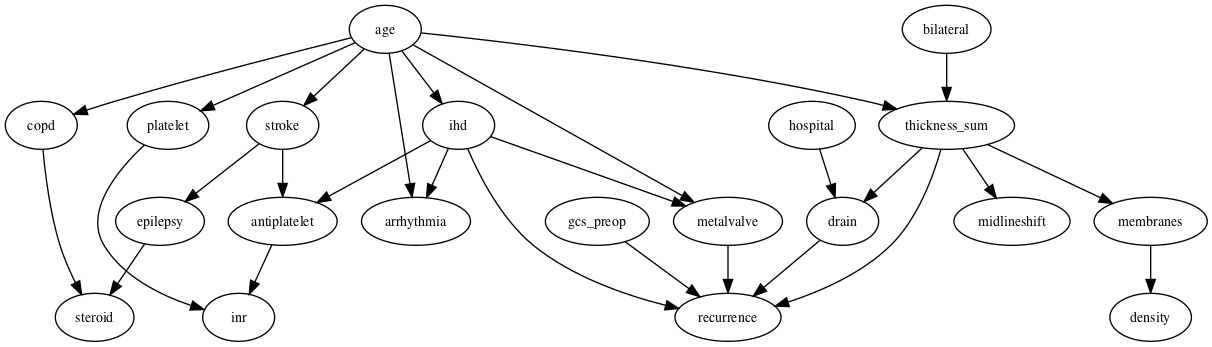

In [7]:
data_model = CausalModel(data=csdh, 
                         treatment='drain', 
                         outcome='recurrence', 
                         graph='../causal_graphs/data_dag.dot'.replace("\n", " "))
data_model.view_model()
from IPython.display import Image, display
display(Image(filename="causal_model.png"))

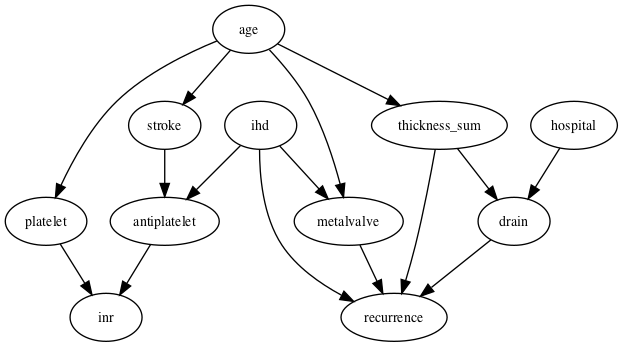

In [8]:
small_data_model = CausalModel(data=csdh,
                               treatment='drain', 
                               outcome='recurrence', 
                               graph='../causal_graphs/small_data_dag.dot'.replace("\n", " "))
small_data_model.view_model()
from IPython.display import Image, display
display(Image(filename="causal_model.png"))

---
## II. Identify a target estimand under the model

In [9]:
data_estimand = data_model.identify_effect(proceed_when_unidentifiable=True)
small_data_estimand = small_data_model.identify_effect(proceed_when_unidentifiable=True)

---
## III. Instrumental variable (IV; hospital) estimator

### This estimate applies to the `data_model` and `small_data_model` only; `mp_model` contains no instruments.

The instrumental variables approach attempts to estimate the effect of $T$ on $Y$ with the help of a third variable  $Z$ that is correlated with $T$ but is uncorrelated with the error term for $Y$. In other words, the instrument $Z$ is only related with $Y$ through the directed path that goes through $T$. If these conditions are satisfied, the effect of $T$ on $Y$ can be estimated using the sample analog of:

$$\frac{Cov(Y_i, Z_i)}{Cov(T_i, Z_i)}$$

The most common method for instrumental variables estimation is the two-stage least squares (2SLS). In this approach, the cause variable $T$ is first regressed on the instrument $Z$. Then, in the second stage, the outcome of interest $Y$ is regressed on the predicted value from the first-stage model. Intuitively, the effect of $T$ on $Y$ is estimated by using only the proportion of variation in $T$ due to variation in $Z$. See https://www.aeaweb.org/articles?id=10.1257/jep.15.4.69  for a detailed discussion of the method.

In [14]:
# Wald estimate method
data_iv_est = data_model.estimate_effect(data_estimand,
                                         control_value=0,
                                         treatment_value=1,
                                         method_name='iv.instrumental_variable',
                                         method_params={'iv_instrument_name': 'hospital'},
                                         test_significance=True, 
                                         confidence_intervals=True)

In [15]:
# Wald estimate method
sdata_iv_est = small_data_model.estimate_effect(small_data_estimand,
                                                control_value=0,
                                                treatment_value=1,
                                                method_name='iv.instrumental_variable',
                                                method_params={'iv_instrument_name': 'hospital'},
                                                test_significance=True, 
                                                confidence_intervals=True)

In [16]:
print(data_iv_est)

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: iv
Estimand expression:
Expectation(Derivative(recurrence, [hospital])*Derivative([drain], [hospital])
**(-1))
Estimand assumption 1, As-if-random: If U→→recurrence then ¬(U →→{hospital})
Estimand assumption 2, Exclusion: If we remove {hospital}→{drain}, then ¬({hospital}→recurrence)

## Realized estimand
Realized estimand: Wald Estimator
Realized estimand type: nonparametric-ate
Estimand expression:
                                                                              
Expectation(Derivative(recurrence, hospital))⋅Expectation(Derivative(drain, ho

        -1
spital))  
Estimand assumption 1, As-if-random: If U→→recurrence then ¬(U →→{hospital})
Estimand assumption 2, Exclusion: If we remove {hospital}→{drain}, then ¬({hospital}→recurrence)
Estimand assumption 3, treatment_effect_homogeneity: Each unit's treatment ['drain'] is affected in the same way by common caus

In [17]:
print(sdata_iv_est)

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: iv
Estimand expression:
Expectation(Derivative(recurrence, [hospital])*Derivative([drain], [hospital])
**(-1))
Estimand assumption 1, As-if-random: If U→→recurrence then ¬(U →→{hospital})
Estimand assumption 2, Exclusion: If we remove {hospital}→{drain}, then ¬({hospital}→recurrence)

## Realized estimand
Realized estimand: Wald Estimator
Realized estimand type: nonparametric-ate
Estimand expression:
                                                                              
Expectation(Derivative(recurrence, hospital))⋅Expectation(Derivative(drain, ho

        -1
spital))  
Estimand assumption 1, As-if-random: If U→→recurrence then ¬(U →→{hospital})
Estimand assumption 2, Exclusion: If we remove {hospital}→{drain}, then ¬({hospital}→recurrence)
Estimand assumption 3, treatment_effect_homogeneity: Each unit's treatment ['drain'] is affected in the same way by common caus

In [18]:
# Two-Stage Least-Squares (2SLS) Regression
# We see congruence between this and the DoWhy method
rec_vec, endog = ps.dmatrices("recurrence ~ drain", data=csdh)
exog = ps.dmatrix("hospital", data=csdh)

m = IV2SLS(rec_vec, endog, exog).fit()
m.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                          IV2SLS Regression Results                           
==============================================================================
Dep. Variable:             recurrence   R-squared:                      -0.043
Model:                         IV2SLS   Adj. R-squared:                 -0.045
Method:                     Two Stage   F-statistic:                     1.067
                        Least Squares   Prob (F-statistic):              0.302
Date:                Mon, 05 Jul 2021                                         
Time:                        10:22:50                                         
No. Observations:                 745                                         
Df Residuals:                     743                                         
Df Model:                           1                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.3273      0.228      1.439      0.151      -0.119       0.774
drain         -0.2811      0.272     -1.033      0.302      -0.815       0.253
==============================================================================
Omnibus:                      352.300   Durbin-Watson:                   1.923
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1397.168
Skew:                           2.296   Prob(JB):                    4.06e-304
Kurtosis:                       7.891   Cond. No.                         4.73
==============================================================================
"""

## For IV methods, only the treatment, outcome and instrument are important; the rest of the causal graph is ignored. This explains why firstly the instrumental variable method differs so greatly from other estimation techniques and why the `data_model` and `small_data_model` are perfectly congruent.

### We carry on the rest of this notebook using the `small_data_model` since it is more lightweight and hence runs faster.

In [25]:
# small data model
dwh.print_estimate_comparison(naive_est, sdata_iv_est, 'Instrumental variable')

-------------- Causal Estimates -------------- 
Naive causal estimate is -0.09356128931064231
Instrumental variable causal estimate is -0.28110039057421726
Percentage change from naive_est: 200.445%
----------------------------------------------


In [24]:
# data model
dwh.print_estimate_comparison(naive_est, data_iv_est, 'Instrumental variable')

-------------- Causal Estimates -------------- 
Naive causal estimate is -0.09356128931064231
Instrumental variable causal estimate is -0.28110039057421726
Percentage change from naive_est: 200.445%
----------------------------------------------


---
## IV. Refute the obtained estimate

1. **Add Random Common Cause:** Does the estimation method change its estimate after we add an independent random variable as a common cause to the dataset? (Hint: It should not)

In [28]:
# Robust if: estimate stays the same
iv_ran_refuter = small_data_model.refute_estimate(small_data_estimand,
                                                  sdata_iv_est,
                                                  num_simulations=100,
                                                  method_name="random_common_cause")

2. **Placebo Treatment:** What happens to the estimated causal effect when we replace the true treatment variable with an independent random variable? (Hint: the effect should go to zero)


- Note that the placebo type is 'permute' meaning the rows of the treatment variable have been randomly permuted giving the effect of a placebo treatment.

In [30]:
# Robust if: estimate goes to 0
iv_placebo_refuter = small_data_model.refute_estimate(small_data_estimand, 
                                                      sdata_iv_est,
                                                      method_name="placebo_treatment_refuter",
                                                      num_simulations=100,
                                                      placebo_type='permute')

3. **Dummy Outcome:** What happens to the estimated causal effect when we replace the true outcome variable with an independent random variable? (Hint: The effect should go to zero)


- The result shows that when using a dummy outcome, the **treatment does not lead to the outcome**. The estimated effect is hence a value that tends to zero, which matches our expectation. This shows that if we replace the outcome by randomly generated data, the **estimator correctly predicts that the influence if treatment is zero**.

In [31]:
#### NOT APPLICABLE TO IV ESTIMATION METHODS ########
# Robust if: estimate goes to 0
# iv_dummy_refuter = data_model.refute_estimate(data_estimand,
#                                               data_iv_est,
#                                               method_name="dummy_outcome_refuter")

4. **Data Subsets Validation:** Does the estimated effect change significantly when we replace the given dataset with a randomly selected subset? (Hint: It should not)

In [32]:
# Robust if: estimate stays the same
iv_subset_refuter = small_data_model.refute_estimate(small_data_estimand, 
                                                     sdata_iv_est,
                                                     method_name="data_subset_refuter",
                                                     num_simulations=100,
                                                     subset_fraction=0.75)

5. **Bootstrap Validation:** Does the estimated effect change significantly when we replace the given dataset with bootstrapped samples from the same dataset? (Hint: It should not)

In [34]:
# Robust if: estimate stays the same
iv_bootstrap_refuter = small_data_model.refute_estimate(small_data_estimand, 
                                                        sdata_iv_est,
                                                        method_name="bootstrap_refuter", 
                                                        num_simulations=100)

In [35]:
print(iv_ran_refuter)

Refute: Add a Random Common Cause
Estimated effect:-0.28110039057421726
New effect:-0.28110039057421726



In [36]:
print(iv_placebo_refuter)

Refute: Use a Placebo Treatment
Estimated effect:-0.28110039057421726
New effect:0.003687280619944968
p value:0.49



In [37]:
print(iv_subset_refuter)

Refute: Use a subset of data
Estimated effect:-0.28110039057421726
New effect:-0.297031230083872
p value:0.48



In [38]:
print(iv_bootstrap_refuter)

Refute: Bootstrap Sample Dataset
Estimated effect:-0.28110039057421726
New effect:-0.25066498481613725
p value:0.41



---
# iii. Deep IV Estimator

In [55]:
dims_zx = len(small_data_model._instruments)+len(small_data_model._effect_modifiers)
dims_tx = len(small_data_model._treatment)+len(small_data_model._effect_modifiers)

In [56]:
treatment_model = keras.Sequential([keras.layers.Dense(128, activation='relu', input_shape=(dims_zx,)), # sum of dims of Z and X
                                    keras.layers.Dropout(0.17),
                                    keras.layers.Dense(64, activation='relu'),
                                    keras.layers.Dropout(0.17),
                                    keras.layers.Dense(26, activation='relu'),
                                    keras.layers.Dropout(0.17)])

response_model = keras.Sequential([keras.layers.Dense(128, activation='relu', input_shape=(dims_tx,)), # sum of dims of T and X
                                   keras.layers.Dropout(0.17),
                                   keras.layers.Dense(64, activation='relu'),
                                   keras.layers.Dense(32, activation='relu'),
                                   keras.layers.Dropout(0.17),
                                   keras.layers.Dense(1, activation='sigmoid')])

In [57]:
small_deepiv_estimate = small_data_model.estimate_effect(small_data_estimand,
                                                         method_name="iv.econml.iv.nnet.DeepIV",
                                                         control_value=0,
                                                         treatment_value=1,
                                                         confidence_intervals=False,
                                                         target_units='ate',
                                                         method_params={"init_params":{'n_components': 10, # Number of gaussians in the mixture density networks
                                                                                       'm': lambda z, x: treatment_model(keras.layers.concatenate([z, x])), # Treatment model,
                                                                                       "h": lambda t, x: response_model(keras.layers.concatenate([t, x])), # Response model
                                                                                       'n_samples': 100, # Number of samples used to estimate the response
                                                                                       'first_stage_options':{'epochs':500},
                                                                                       'second_stage_options':{'epochs':20}
                                                                                      },
                                                                        "fit_params":{}
                                                                       }
                                                        )

Epoch 1/500
745/745 [==============================] - 31s 42ms/step - loss: 0.5664
Epoch 2/500
745/745 [==============================] - 0s 619us/step - loss: 0.3002
Epoch 3/500
745/745 [==============================] - 0s 569us/step - loss: 0.2212
Epoch 4/500
745/745 [==============================] - 0s 630us/step - loss: 0.1674
Epoch 5/500
745/745 [==============================] - 0s 623us/step - loss: 0.0701
Epoch 6/500
745/745 [==============================] - 0s 643us/step - loss: -0.0264
Epoch 7/500
745/745 [==============================] - 0s 603us/step - loss: -0.0622
Epoch 8/500
745/745 [==============================] - 0s 595us/step - loss: -0.1568
Epoch 9/500
745/745 [==============================] - 0s 590us/step - loss: -0.2419
Epoch 10/500
745/745 [==============================] - 0s 600us/step - loss: -0.2786
Epoch 11/500
745/745 [==============================] - 0s 608us/step - loss: -0.3323
Epoch 12/500
745/745 [==============================] - 0s 577us/ste

745/745 [==============================] - 0s 587us/step - loss: -3.6233
Epoch 97/500
745/745 [==============================] - 0s 577us/step - loss: -3.7162
Epoch 98/500
745/745 [==============================] - 0s 604us/step - loss: -3.5715
Epoch 99/500
745/745 [==============================] - 0s 597us/step - loss: -3.6433
Epoch 100/500
745/745 [==============================] - 0s 621us/step - loss: -3.4849
Epoch 101/500
745/745 [==============================] - 0s 610us/step - loss: -2.8729
Epoch 102/500
745/745 [==============================] - 0s 604us/step - loss: -3.1123
Epoch 103/500
745/745 [==============================] - 0s 582us/step - loss: -3.0791
Epoch 104/500
745/745 [==============================] - 0s 626us/step - loss: -3.3328
Epoch 105/500
745/745 [==============================] - 0s 654us/step - loss: -3.2835
Epoch 106/500
745/745 [==============================] - 0s 626us/step - loss: -3.4139
Epoch 107/500
745/745 [==============================] - 0s 

745/745 [==============================] - 1s 711us/step - loss: -4.7936
Epoch 191/500
745/745 [==============================] - 1s 821us/step - loss: -4.7047
Epoch 192/500
745/745 [==============================] - 1s 770us/step - loss: -4.6273
Epoch 193/500
745/745 [==============================] - 1s 757us/step - loss: -4.6665
Epoch 194/500
745/745 [==============================] - 1s 766us/step - loss: -4.7673
Epoch 195/500
745/745 [==============================] - 1s 778us/step - loss: -4.8067
Epoch 196/500
745/745 [==============================] - 1s 795us/step - loss: -4.7938
Epoch 197/500
745/745 [==============================] - 1s 777us/step - loss: -4.8602
Epoch 198/500
745/745 [==============================] - 1s 780us/step - loss: -4.8932
Epoch 199/500
745/745 [==============================] - 1s 801us/step - loss: -4.8977
Epoch 200/500
745/745 [==============================] - 1s 793us/step - loss: -4.8470
Epoch 201/500
745/745 [==============================] - 

745/745 [==============================] - 1s 679us/step - loss: -5.5453
Epoch 285/500
745/745 [==============================] - 1s 723us/step - loss: -5.4375
Epoch 286/500
745/745 [==============================] - 0s 660us/step - loss: -5.7546
Epoch 287/500
745/745 [==============================] - 0s 648us/step - loss: -5.7149
Epoch 288/500
745/745 [==============================] - 0s 656us/step - loss: -5.7409
Epoch 289/500
745/745 [==============================] - 1s 871us/step - loss: -5.8252
Epoch 290/500
745/745 [==============================] - 1s 764us/step - loss: -5.9129
Epoch 291/500
745/745 [==============================] - 1s 966us/step - loss: -5.7383
Epoch 292/500
745/745 [==============================] - 1s 753us/step - loss: -5.7112
Epoch 293/500
745/745 [==============================] - 1s 732us/step - loss: -5.7818
Epoch 294/500
745/745 [==============================] - 1s 689us/step - loss: -5.6872
Epoch 295/500
745/745 [==============================] - 

745/745 [==============================] - 0s 594us/step - loss: -6.2800
Epoch 379/500
745/745 [==============================] - 0s 588us/step - loss: -6.4702
Epoch 380/500
745/745 [==============================] - 0s 612us/step - loss: -3.7670
Epoch 381/500
745/745 [==============================] - 0s 628us/step - loss: -3.9097
Epoch 382/500
745/745 [==============================] - 0s 633us/step - loss: -6.0523
Epoch 383/500
745/745 [==============================] - 1s 683us/step - loss: -6.3406
Epoch 384/500
745/745 [==============================] - 0s 655us/step - loss: -6.3961
Epoch 385/500
745/745 [==============================] - 0s 642us/step - loss: -6.4766
Epoch 386/500
745/745 [==============================] - 0s 588us/step - loss: -5.9773
Epoch 387/500
745/745 [==============================] - 0s 581us/step - loss: -6.0683
Epoch 388/500
745/745 [==============================] - 0s 594us/step - loss: -6.3544
Epoch 389/500
745/745 [==============================] - 

745/745 [==============================] - 0s 579us/step - loss: -5.9816
Epoch 473/500
745/745 [==============================] - 0s 615us/step - loss: -6.3151
Epoch 474/500
745/745 [==============================] - 0s 586us/step - loss: -6.2215
Epoch 475/500
745/745 [==============================] - 0s 606us/step - loss: -6.0218
Epoch 476/500
745/745 [==============================] - 0s 613us/step - loss: -6.3391
Epoch 477/500
745/745 [==============================] - 0s 637us/step - loss: -6.4471
Epoch 478/500
745/745 [==============================] - 0s 589us/step - loss: -4.2616
Epoch 479/500
745/745 [==============================] - 0s 583us/step - loss: -5.9091
Epoch 480/500
745/745 [==============================] - 0s 576us/step - loss: -6.1674
Epoch 481/500
745/745 [==============================] - 0s 570us/step - loss: -5.8969
Epoch 482/500
745/745 [==============================] - 0s 570us/step - loss: -6.1077
Epoch 483/500
745/745 [==============================] - 

In [58]:
print(small_deepiv_estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: iv
Estimand expression:
Expectation(Derivative(recurrence, [hospital])*Derivative([drain], [hospital])
**(-1))
Estimand assumption 1, As-if-random: If U→→recurrence then ¬(U →→{hospital})
Estimand assumption 2, Exclusion: If we remove {hospital}→{drain}, then ¬({hospital}→recurrence)

## Realized estimand
b: recurrence~drain+metalvalve+stroke+age+antiplatelet+inr+ihd+platelet+thickness_sum | ihd,metalvalve
Target units: ate

## Estimate
Mean value: -0.16557924449443817
Effect estimates: [-0.14561975 -0.14561975 -0.14561975 -0.14561975 -0.14561975 -0.14561975
 -0.14561975 -0.14561975 -0.14561975 -0.14561975 -0.14561975 -0.14561975
 -0.14561975 -0.14561975 -0.14561975 -0.14561975 -0.14561975 -0.14561975
 -0.14561975 -0.14561975 -0.22528201 -0.14561975 -0.14561975 -0.14561975
 -0.14561975 -0.14561975 -0.14561975 -0.22528201 -0.14561975 -0.14561975
 -0.14561975 -0.14561975 -0.1

In [60]:
# small data model
dwh.print_estimate_comparison(naive_est, small_deepiv_estimate, 'DeepIV')

-------------- Causal Estimates -------------- 
Naive causal estimate is -0.09356128931064231
DeepIV causal estimate is -0.16557924
Percentage change from naive_est: 76.974%
----------------------------------------------


---
## IV. Refute the obtained estimate

1. **Add Random Common Cause:** Does the estimation method change its estimate after we add an independent random variable as a common cause to the dataset? (Hint: It should not)

In [61]:
div_ran_refuter = small_data_model.refute_estimate(small_data_estimand,
                                                   small_deepiv_estimate, 
                                                   method_name="random_common_cause", 
                                                   num_simulations=5)

Epoch 1/500
745/745 [==============================] - 28s 37ms/step - loss: 0.3635
Epoch 2/500
745/745 [==============================] - 1s 692us/step - loss: 0.1930
Epoch 3/500
745/745 [==============================] - 1s 682us/step - loss: 0.0367
Epoch 4/500
745/745 [==============================] - 1s 702us/step - loss: -0.1236
Epoch 5/500
745/745 [==============================] - 1s 723us/step - loss: -0.2651
Epoch 6/500
745/745 [==============================] - 1s 714us/step - loss: -0.4006
Epoch 7/500
745/745 [==============================] - 1s 696us/step - loss: -0.5422
Epoch 8/500
745/745 [==============================] - 1s 703us/step - loss: -0.6728
Epoch 9/500
745/745 [==============================] - 1s 714us/step - loss: -0.8345
Epoch 10/500
745/745 [==============================] - 1s 704us/step - loss: -0.9803
Epoch 11/500
745/745 [==============================] - 1s 703us/step - loss: -1.0651
Epoch 12/500
745/745 [==============================] - 1s 710us/s

745/745 [==============================] - 1s 703us/step - loss: -2.9586
Epoch 97/500
745/745 [==============================] - 1s 704us/step - loss: -2.9415
Epoch 98/500
745/745 [==============================] - 1s 695us/step - loss: -2.7304
Epoch 99/500
745/745 [==============================] - 1s 711us/step - loss: -2.6372
Epoch 100/500
745/745 [==============================] - 1s 708us/step - loss: -3.2836
Epoch 101/500
745/745 [==============================] - 1s 688us/step - loss: -3.6968
Epoch 102/500
745/745 [==============================] - 1s 704us/step - loss: -4.0579
Epoch 103/500
745/745 [==============================] - 1s 708us/step - loss: -4.4178
Epoch 104/500
745/745 [==============================] - 1s 704us/step - loss: -2.4786
Epoch 105/500
745/745 [==============================] - 1s 721us/step - loss: -1.6230
Epoch 106/500
745/745 [==============================] - 1s 707us/step - loss: -2.6158
Epoch 107/500
745/745 [==============================] - 1s 

745/745 [==============================] - 0s 580us/step - loss: -3.8514
Epoch 191/500
745/745 [==============================] - 0s 567us/step - loss: -4.2860
Epoch 192/500
745/745 [==============================] - 0s 567us/step - loss: -4.2156
Epoch 193/500
745/745 [==============================] - 0s 571us/step - loss: -4.4228
Epoch 194/500
745/745 [==============================] - 0s 561us/step - loss: -4.4701
Epoch 195/500
745/745 [==============================] - 0s 585us/step - loss: -4.4723
Epoch 196/500
745/745 [==============================] - 0s 621us/step - loss: -4.4301
Epoch 197/500
745/745 [==============================] - 0s 645us/step - loss: -4.4745
Epoch 198/500
745/745 [==============================] - 0s 636us/step - loss: -4.5609
Epoch 199/500
745/745 [==============================] - 1s 678us/step - loss: -4.6547
Epoch 200/500
745/745 [==============================] - 1s 699us/step - loss: -4.6987
Epoch 201/500
745/745 [==============================] - 

745/745 [==============================] - 0s 606us/step - loss: -4.7764
Epoch 285/500
745/745 [==============================] - 0s 605us/step - loss: -4.1658
Epoch 286/500
745/745 [==============================] - 0s 603us/step - loss: -3.0839
Epoch 287/500
745/745 [==============================] - 0s 602us/step - loss: -4.3466
Epoch 288/500
745/745 [==============================] - 0s 644us/step - loss: -4.7103
Epoch 289/500
745/745 [==============================] - 0s 628us/step - loss: -4.3921
Epoch 290/500
745/745 [==============================] - 0s 635us/step - loss: -4.6045
Epoch 291/500
745/745 [==============================] - 0s 645us/step - loss: -4.8424
Epoch 292/500
745/745 [==============================] - 0s 649us/step - loss: -4.6168
Epoch 293/500
745/745 [==============================] - 0s 645us/step - loss: -5.1294
Epoch 294/500
745/745 [==============================] - 0s 647us/step - loss: -5.1547
Epoch 295/500
745/745 [==============================] - 

745/745 [==============================] - 0s 564us/step - loss: -4.3394
Epoch 379/500
745/745 [==============================] - 0s 561us/step - loss: -4.5763
Epoch 380/500
745/745 [==============================] - 0s 569us/step - loss: -4.7343
Epoch 381/500
745/745 [==============================] - 0s 570us/step - loss: -4.8821
Epoch 382/500
745/745 [==============================] - 0s 563us/step - loss: -4.7418
Epoch 383/500
745/745 [==============================] - 0s 557us/step - loss: -4.7548
Epoch 384/500
745/745 [==============================] - 0s 575us/step - loss: -4.7973
Epoch 385/500
745/745 [==============================] - 0s 583us/step - loss: -4.8854
Epoch 386/500
745/745 [==============================] - 0s 588us/step - loss: -4.8835
Epoch 387/500
745/745 [==============================] - 0s 576us/step - loss: -5.0087
Epoch 388/500
745/745 [==============================] - 0s 618us/step - loss: -5.0081
Epoch 389/500
745/745 [==============================] - 

745/745 [==============================] - 1s 755us/step - loss: -5.5732
Epoch 473/500
745/745 [==============================] - 1s 780us/step - loss: -5.7474
Epoch 474/500
745/745 [==============================] - 1s 732us/step - loss: -5.6944
Epoch 475/500
745/745 [==============================] - 1s 737us/step - loss: -5.7203
Epoch 476/500
745/745 [==============================] - 1s 804us/step - loss: -3.6346
Epoch 477/500
745/745 [==============================] - 1s 770us/step - loss: -3.4436
Epoch 478/500
745/745 [==============================] - 1s 778us/step - loss: -4.0603
Epoch 479/500
745/745 [==============================] - 1s 765us/step - loss: -4.2840
Epoch 480/500
745/745 [==============================] - 1s 772us/step - loss: -4.2942
Epoch 481/500
745/745 [==============================] - 1s 782us/step - loss: -5.0936
Epoch 482/500
745/745 [==============================] - 1s 745us/step - loss: -5.1660
Epoch 483/500
745/745 [==============================] - 

In [62]:
# Robust if: new effect is similar to estimated effect
print(div_ran_refuter)

Refute: Add a Random Common Cause
Estimated effect:-0.16557924449443817
New effect:-0.17148487269878387



2. **Placebo Treatment:** What happens to the estimated causal effect when we replace the true treatment variable with an independent random variable? (Hint: the effect should go to zero)



* Note that the placebo type is 'permute' meaning the rows of the treatment variable have been randomly permuted giving the effect of a placebo treatment.


In [63]:
# Robust if: new effect is close to 0
div_placebo_refuter = small_data_model.refute_estimate(small_data_estimand,
                                                       small_deepiv_estimate, 
                                                       method_name="placebo_treatment_refuter", 
                                                       placebo_type='permute',
                                                       num_simulations=5)

Epoch 1/500
745/745 [==============================] - 48s 64ms/step - loss: 0.5033
Epoch 2/500
745/745 [==============================] - 1s 801us/step - loss: 0.2615
Epoch 3/500
745/745 [==============================] - 1s 802us/step - loss: 0.0647
Epoch 4/500
745/745 [==============================] - 1s 798us/step - loss: -0.0972
Epoch 5/500
745/745 [==============================] - 1s 805us/step - loss: -0.2132
Epoch 6/500
745/745 [==============================] - 1s 801us/step - loss: -0.3263
Epoch 7/500
745/745 [==============================] - 1s 814us/step - loss: -0.4261
Epoch 8/500
745/745 [==============================] - 1s 806us/step - loss: -0.5772
Epoch 9/500
745/745 [==============================] - 1s 799us/step - loss: -0.7486
Epoch 10/500
745/745 [==============================] - 1s 805us/step - loss: -0.9580
Epoch 11/500
745/745 [==============================] - 1s 801us/step - loss: -1.2234
Epoch 12/500
745/745 [==============================] - 1s 811us/s

745/745 [==============================] - 1s 827us/step - loss: -4.6490
Epoch 97/500
745/745 [==============================] - 1s 830us/step - loss: -4.7174
Epoch 98/500
745/745 [==============================] - 1s 826us/step - loss: -4.7131
Epoch 99/500
745/745 [==============================] - 1s 827us/step - loss: -4.7304
Epoch 100/500
745/745 [==============================] - 1s 831us/step - loss: -3.4703
Epoch 101/500
745/745 [==============================] - 1s 831us/step - loss: -2.8969
Epoch 102/500
745/745 [==============================] - 1s 815us/step - loss: -2.9277
Epoch 103/500
745/745 [==============================] - 1s 821us/step - loss: -4.0125
Epoch 104/500
745/745 [==============================] - 1s 829us/step - loss: -4.3987
Epoch 105/500
745/745 [==============================] - 1s 827us/step - loss: -4.4937
Epoch 106/500
745/745 [==============================] - 1s 825us/step - loss: -4.7700
Epoch 107/500
745/745 [==============================] - 1s 

745/745 [==============================] - 1s 893us/step - loss: -4.8232
Epoch 191/500
745/745 [==============================] - 1s 877us/step - loss: -4.8855
Epoch 192/500
745/745 [==============================] - 1s 874us/step - loss: -4.6809
Epoch 193/500
745/745 [==============================] - 1s 886us/step - loss: -4.8126
Epoch 194/500
745/745 [==============================] - 1s 881us/step - loss: -4.8834
Epoch 195/500
745/745 [==============================] - 1s 877us/step - loss: -4.9904
Epoch 196/500
745/745 [==============================] - 1s 876us/step - loss: -5.0174
Epoch 197/500
745/745 [==============================] - 1s 873us/step - loss: -4.8086
Epoch 198/500
745/745 [==============================] - 1s 872us/step - loss: -4.9323
Epoch 199/500
745/745 [==============================] - 1s 878us/step - loss: -4.9122
Epoch 200/500
745/745 [==============================] - 1s 882us/step - loss: -4.9114
Epoch 201/500
745/745 [==============================] - 

745/745 [==============================] - 1s 801us/step - loss: -5.1908
Epoch 285/500
745/745 [==============================] - 1s 808us/step - loss: -5.2179
Epoch 286/500
745/745 [==============================] - 1s 810us/step - loss: -5.2864
Epoch 287/500
745/745 [==============================] - 1s 814us/step - loss: -5.3404
Epoch 288/500
745/745 [==============================] - 1s 811us/step - loss: -5.3512
Epoch 289/500
745/745 [==============================] - 1s 814us/step - loss: -5.4303
Epoch 290/500
745/745 [==============================] - 1s 803us/step - loss: -5.4752
Epoch 291/500
745/745 [==============================] - 1s 810us/step - loss: -5.4681
Epoch 292/500
745/745 [==============================] - 1s 814us/step - loss: -5.4445
Epoch 293/500
745/745 [==============================] - 1s 824us/step - loss: -5.4997
Epoch 294/500
745/745 [==============================] - 1s 806us/step - loss: -5.2749
Epoch 295/500
745/745 [==============================] - 

745/745 [==============================] - 1s 925us/step - loss: -5.5435
Epoch 379/500
745/745 [==============================] - 1s 970us/step - loss: -5.7887
Epoch 380/500
745/745 [==============================] - 1s 919us/step - loss: -5.8470
Epoch 381/500
745/745 [==============================] - 1s 887us/step - loss: -5.9673
Epoch 382/500
745/745 [==============================] - 1s 881us/step - loss: -6.0132
Epoch 383/500
745/745 [==============================] - 1s 912us/step - loss: -6.0624
Epoch 384/500
745/745 [==============================] - 1s 914us/step - loss: -6.0946
Epoch 385/500
745/745 [==============================] - 1s 880us/step - loss: -6.1004
Epoch 386/500
745/745 [==============================] - 1s 861us/step - loss: -6.2021
Epoch 387/500
745/745 [==============================] - 1s 859us/step - loss: -6.1484
Epoch 388/500
745/745 [==============================] - 1s 853us/step - loss: -6.1586
Epoch 389/500
745/745 [==============================] - 

745/745 [==============================] - 1s 866us/step - loss: -5.7721
Epoch 473/500
745/745 [==============================] - 1s 852us/step - loss: -5.4413
Epoch 474/500
745/745 [==============================] - 1s 845us/step - loss: -5.5598
Epoch 475/500
745/745 [==============================] - 1s 833us/step - loss: -5.6933
Epoch 476/500
745/745 [==============================] - 1s 826us/step - loss: -5.3337
Epoch 477/500
745/745 [==============================] - 1s 830us/step - loss: -5.6188
Epoch 478/500
745/745 [==============================] - 1s 845us/step - loss: -5.5714
Epoch 479/500
745/745 [==============================] - 1s 964us/step - loss: -5.4750
Epoch 480/500
745/745 [==============================] - 1s 894us/step - loss: -5.5326
Epoch 481/500
745/745 [==============================] - 1s 916us/step - loss: -5.5423
Epoch 482/500
745/745 [==============================] - 1s 876us/step - loss: -5.3800
Epoch 483/500
745/745 [==============================] - 

745/745 [==============================] - 1s 1ms/step - loss: -1.6135
Epoch 49/500
745/745 [==============================] - 1s 992us/step - loss: -1.6344
Epoch 50/500
745/745 [==============================] - 1s 984us/step - loss: -1.3843
Epoch 51/500
745/745 [==============================] - 1s 980us/step - loss: -1.7244
Epoch 52/500
745/745 [==============================] - 1s 960us/step - loss: -2.4122
Epoch 53/500
745/745 [==============================] - 1s 987us/step - loss: -0.2980
Epoch 54/500
745/745 [==============================] - 1s 978us/step - loss: -0.4001
Epoch 55/500
745/745 [==============================] - 1s 962us/step - loss: -0.7882
Epoch 56/500
745/745 [==============================] - 1s 975us/step - loss: -1.5549
Epoch 57/500
745/745 [==============================] - 1s 972us/step - loss: -2.2960
Epoch 58/500
745/745 [==============================] - 1s 1ms/step - loss: -2.8014
Epoch 59/500
745/745 [==============================] - 1s 985us/step -

745/745 [==============================] - 1s 1ms/step - loss: -3.7600
Epoch 145/500
745/745 [==============================] - 1s 1ms/step - loss: -2.4995
Epoch 146/500
745/745 [==============================] - 1s 1ms/step - loss: -2.9307
Epoch 147/500
745/745 [==============================] - 1s 1ms/step - loss: -3.0858
Epoch 148/500
745/745 [==============================] - 1s 1ms/step - loss: -2.9321
Epoch 149/500
745/745 [==============================] - 1s 1ms/step - loss: -3.5143
Epoch 150/500
745/745 [==============================] - 1s 1ms/step - loss: -3.8276
Epoch 151/500
745/745 [==============================] - 1s 1ms/step - loss: -2.7138
Epoch 152/500
745/745 [==============================] - 1s 1ms/step - loss: -2.2813
Epoch 153/500
745/745 [==============================] - 1s 1ms/step - loss: -2.6967
Epoch 154/500
745/745 [==============================] - 1s 1ms/step - loss: -2.6112
Epoch 155/500
745/745 [==============================] - 1s 1ms/step - loss: -2

745/745 [==============================] - 1s 1ms/step - loss: -1.4940
Epoch 241/500
745/745 [==============================] - 1s 1ms/step - loss: -4.0709
Epoch 242/500
745/745 [==============================] - 1s 1ms/step - loss: -4.3420
Epoch 243/500
745/745 [==============================] - 1s 1ms/step - loss: -4.5465
Epoch 244/500
745/745 [==============================] - 1s 1ms/step - loss: -4.5549
Epoch 245/500
745/745 [==============================] - 1s 1ms/step - loss: -3.7208
Epoch 246/500
745/745 [==============================] - 1s 1ms/step - loss: -4.3774
Epoch 247/500
745/745 [==============================] - 1s 1ms/step - loss: -4.5419
Epoch 248/500
745/745 [==============================] - 1s 1ms/step - loss: -4.5809
Epoch 249/500
745/745 [==============================] - 1s 1ms/step - loss: -4.2624
Epoch 250/500
745/745 [==============================] - 1s 1ms/step - loss: -4.4451
Epoch 251/500
745/745 [==============================] - 1s 1ms/step - loss: -4

745/745 [==============================] - 1s 994us/step - loss: -4.8107
Epoch 337/500
745/745 [==============================] - 1s 992us/step - loss: -4.7642
Epoch 338/500
745/745 [==============================] - 1s 992us/step - loss: -4.9473
Epoch 339/500
745/745 [==============================] - 1s 992us/step - loss: -5.0053
Epoch 340/500
745/745 [==============================] - 1s 1ms/step - loss: -1.8726
Epoch 341/500
745/745 [==============================] - 1s 990us/step - loss: -4.2176
Epoch 342/500
745/745 [==============================] - 1s 1ms/step - loss: -4.5981
Epoch 343/500
745/745 [==============================] - 1s 1ms/step - loss: -4.7139
Epoch 344/500
745/745 [==============================] - 1s 1ms/step - loss: -4.7842
Epoch 345/500
745/745 [==============================] - 1s 1ms/step - loss: -4.8978
Epoch 346/500
745/745 [==============================] - 1s 1ms/step - loss: -4.9421
Epoch 347/500
745/745 [==============================] - 1s 1ms/step 

745/745 [==============================] - 1s 1ms/step - loss: -5.2062
Epoch 432/500
745/745 [==============================] - 1s 1ms/step - loss: -5.0524
Epoch 433/500
745/745 [==============================] - 1s 1ms/step - loss: -5.1847
Epoch 434/500
745/745 [==============================] - 1s 1ms/step - loss: -4.9397
Epoch 435/500
745/745 [==============================] - 1s 1ms/step - loss: -4.2824
Epoch 436/500
745/745 [==============================] - 1s 1ms/step - loss: -5.1831
Epoch 437/500
745/745 [==============================] - 1s 1ms/step - loss: -5.2529
Epoch 438/500
745/745 [==============================] - 1s 1ms/step - loss: -5.3662
Epoch 439/500
745/745 [==============================] - 1s 1ms/step - loss: -5.5259
Epoch 440/500
745/745 [==============================] - 1s 1ms/step - loss: -5.5116
Epoch 441/500
745/745 [==============================] - 1s 1ms/step - loss: 1.1666
Epoch 442/500
745/745 [==============================] - 1s 1ms/step - loss: -3.

745/745 [==============================] - 1s 1ms/step - loss: -0.3639
Epoch 8/500
745/745 [==============================] - 1s 1ms/step - loss: -0.5507
Epoch 9/500
745/745 [==============================] - 1s 1ms/step - loss: -0.6409
Epoch 10/500
745/745 [==============================] - 1s 1ms/step - loss: -0.7404
Epoch 11/500
745/745 [==============================] - 1s 1ms/step - loss: -0.9485
Epoch 12/500
745/745 [==============================] - 1s 1ms/step - loss: -1.2424
Epoch 13/500
745/745 [==============================] - 1s 1ms/step - loss: -1.3400
Epoch 14/500
745/745 [==============================] - 1s 1ms/step - loss: -1.5904
Epoch 15/500
745/745 [==============================] - 1s 1ms/step - loss: -1.8155
Epoch 16/500
745/745 [==============================] - 1s 1ms/step - loss: -2.2613
Epoch 17/500
745/745 [==============================] - 1s 1ms/step - loss: -2.5539
Epoch 18/500
745/745 [==============================] - 1s 1ms/step - loss: -2.8288
Epoch 1

745/745 [==============================] - 1s 1ms/step - loss: -4.5781
Epoch 105/500
745/745 [==============================] - 1s 1ms/step - loss: -4.7996
Epoch 106/500
745/745 [==============================] - 1s 1ms/step - loss: -4.8197
Epoch 107/500
745/745 [==============================] - 1s 1ms/step - loss: -4.8075
Epoch 108/500
745/745 [==============================] - 1s 1ms/step - loss: -4.6370
Epoch 109/500
745/745 [==============================] - 1s 1ms/step - loss: -4.8690
Epoch 110/500
745/745 [==============================] - 1s 1ms/step - loss: -4.9827
Epoch 111/500
745/745 [==============================] - 1s 1ms/step - loss: -5.1744
Epoch 112/500
745/745 [==============================] - 1s 1ms/step - loss: -5.0310
Epoch 113/500
745/745 [==============================] - 1s 1ms/step - loss: -5.2858
Epoch 114/500
745/745 [==============================] - 1s 1ms/step - loss: -5.2337
Epoch 115/500
745/745 [==============================] - 1s 1ms/step - loss: -5

745/745 [==============================] - 1s 1ms/step - loss: -4.8276
Epoch 201/500
745/745 [==============================] - 1s 1ms/step - loss: -4.8458
Epoch 202/500
745/745 [==============================] - 1s 1ms/step - loss: -4.2432
Epoch 203/500
745/745 [==============================] - 1s 1ms/step - loss: -4.5026
Epoch 204/500
745/745 [==============================] - 1s 1ms/step - loss: -5.1717
Epoch 205/500
745/745 [==============================] - 1s 1ms/step - loss: -4.9874
Epoch 206/500
745/745 [==============================] - 1s 1ms/step - loss: -5.0294
Epoch 207/500
745/745 [==============================] - 1s 1ms/step - loss: -5.1527
Epoch 208/500
745/745 [==============================] - 1s 1ms/step - loss: -5.4786
Epoch 209/500
745/745 [==============================] - 1s 1ms/step - loss: -5.4801
Epoch 210/500
745/745 [==============================] - 1s 1ms/step - loss: -5.3098
Epoch 211/500
745/745 [==============================] - 1s 1ms/step - loss: -5

745/745 [==============================] - 1s 1ms/step - loss: -4.7110
Epoch 297/500
745/745 [==============================] - 1s 1ms/step - loss: -4.7611
Epoch 298/500
745/745 [==============================] - 1s 1ms/step - loss: -4.7560
Epoch 299/500
745/745 [==============================] - 1s 1ms/step - loss: -4.7528
Epoch 300/500
745/745 [==============================] - 1s 1ms/step - loss: -4.7512
Epoch 301/500
745/745 [==============================] - 1s 1ms/step - loss: -4.8651
Epoch 302/500
745/745 [==============================] - 1s 1ms/step - loss: -4.7352
Epoch 303/500
745/745 [==============================] - 1s 1ms/step - loss: -4.8700
Epoch 304/500
745/745 [==============================] - 1s 1ms/step - loss: -5.0064
Epoch 305/500
745/745 [==============================] - 1s 1ms/step - loss: -4.9482
Epoch 306/500
745/745 [==============================] - 1s 1ms/step - loss: -4.7218
Epoch 307/500
745/745 [==============================] - 1s 1ms/step - loss: -4

745/745 [==============================] - 1s 1ms/step - loss: -4.8797
Epoch 393/500
745/745 [==============================] - 1s 1ms/step - loss: -4.9628
Epoch 394/500
745/745 [==============================] - 1s 1ms/step - loss: -4.5361
Epoch 395/500
745/745 [==============================] - 1s 1ms/step - loss: -4.6600
Epoch 396/500
745/745 [==============================] - 1s 1ms/step - loss: -4.8700
Epoch 397/500
745/745 [==============================] - 1s 1ms/step - loss: -4.9016
Epoch 398/500
745/745 [==============================] - 1s 1ms/step - loss: -5.0110
Epoch 399/500
745/745 [==============================] - 1s 1ms/step - loss: -5.1054
Epoch 400/500
745/745 [==============================] - 1s 1ms/step - loss: -5.1459
Epoch 401/500
745/745 [==============================] - 1s 1ms/step - loss: -5.2170
Epoch 402/500
745/745 [==============================] - 1s 1ms/step - loss: -5.3562
Epoch 403/500
745/745 [==============================] - 1s 1ms/step - loss: -5

745/745 [==============================] - 1s 1ms/step - loss: -5.1600
Epoch 489/500
745/745 [==============================] - 1s 1ms/step - loss: -5.2309
Epoch 490/500
745/745 [==============================] - 1s 1ms/step - loss: -5.3994
Epoch 491/500
745/745 [==============================] - 1s 1ms/step - loss: -5.3907
Epoch 492/500
745/745 [==============================] - 1s 1ms/step - loss: -5.4967
Epoch 493/500
745/745 [==============================] - 1s 1ms/step - loss: -5.3529
Epoch 494/500
745/745 [==============================] - 1s 1ms/step - loss: -5.4665
Epoch 495/500
745/745 [==============================] - 1s 1ms/step - loss: -5.5455
Epoch 496/500
745/745 [==============================] - 1s 1ms/step - loss: -5.4530
Epoch 497/500
745/745 [==============================] - 1s 1ms/step - loss: -5.1598
Epoch 498/500
745/745 [==============================] - 1s 1ms/step - loss: -5.4935
Epoch 499/500
745/745 [==============================] - 1s 1ms/step - loss: -5

745/745 [==============================] - 1s 1ms/step - loss: -4.7903
Epoch 66/500
745/745 [==============================] - 1s 1ms/step - loss: -4.6773
Epoch 67/500
745/745 [==============================] - 1s 1ms/step - loss: 4.4311
Epoch 68/500
745/745 [==============================] - 1s 1ms/step - loss: 0.0835
Epoch 69/500
745/745 [==============================] - 1s 1ms/step - loss: -1.3691
Epoch 70/500
745/745 [==============================] - 1s 1ms/step - loss: -1.6297
Epoch 71/500
745/745 [==============================] - 1s 1ms/step - loss: -1.6744
Epoch 72/500
745/745 [==============================] - 1s 1ms/step - loss: -1.8806
Epoch 73/500
745/745 [==============================] - 1s 1ms/step - loss: -2.0553
Epoch 74/500
745/745 [==============================] - 1s 1ms/step - loss: -2.0619
Epoch 75/500
745/745 [==============================] - 1s 1ms/step - loss: -2.0951
Epoch 76/500
745/745 [==============================] - 1s 1ms/step - loss: -2.1425
Epoch 7

745/745 [==============================] - 1s 1ms/step - loss: -0.4705
Epoch 163/500
745/745 [==============================] - 1s 1ms/step - loss: -0.3427
Epoch 164/500
745/745 [==============================] - 1s 1ms/step - loss: -0.7094
Epoch 165/500
745/745 [==============================] - 1s 1ms/step - loss: -0.8716
Epoch 166/500
745/745 [==============================] - 1s 1ms/step - loss: -0.8051
Epoch 167/500
745/745 [==============================] - 1s 1ms/step - loss: -1.3124
Epoch 168/500
745/745 [==============================] - 1s 1ms/step - loss: -1.2153
Epoch 169/500
745/745 [==============================] - 1s 1ms/step - loss: -1.4583
Epoch 170/500
745/745 [==============================] - 1s 1ms/step - loss: -1.4006
Epoch 171/500
745/745 [==============================] - 1s 1ms/step - loss: -1.5429
Epoch 172/500
745/745 [==============================] - 1s 1ms/step - loss: -1.5974
Epoch 173/500
745/745 [==============================] - 1s 1ms/step - loss: -2

745/745 [==============================] - 1s 1ms/step - loss: -1.2877
Epoch 259/500
745/745 [==============================] - 1s 1ms/step - loss: -1.3601
Epoch 260/500
745/745 [==============================] - 1s 1ms/step - loss: -1.5962
Epoch 261/500
745/745 [==============================] - 1s 1ms/step - loss: -1.9158
Epoch 262/500
745/745 [==============================] - 1s 1ms/step - loss: -2.0095
Epoch 263/500
745/745 [==============================] - 1s 1ms/step - loss: -2.0710
Epoch 264/500
745/745 [==============================] - 1s 1ms/step - loss: -2.0118
Epoch 265/500
745/745 [==============================] - 1s 1ms/step - loss: -2.0938
Epoch 266/500
745/745 [==============================] - 1s 1ms/step - loss: -2.1104
Epoch 267/500
745/745 [==============================] - 1s 1ms/step - loss: -1.9488
Epoch 268/500
745/745 [==============================] - 1s 1ms/step - loss: -2.3241
Epoch 269/500
745/745 [==============================] - 1s 1ms/step - loss: -2

745/745 [==============================] - 1s 1ms/step - loss: -3.7411
Epoch 355/500
745/745 [==============================] - 1s 1ms/step - loss: -3.3862
Epoch 356/500
745/745 [==============================] - 1s 1ms/step - loss: -3.8795
Epoch 357/500
745/745 [==============================] - 1s 1ms/step - loss: -3.9650
Epoch 358/500
745/745 [==============================] - 1s 1ms/step - loss: -3.7634
Epoch 359/500
745/745 [==============================] - 1s 1ms/step - loss: -3.9323
Epoch 360/500
745/745 [==============================] - 1s 1ms/step - loss: -4.0321
Epoch 361/500
745/745 [==============================] - 1s 1ms/step - loss: -4.2470
Epoch 362/500
745/745 [==============================] - 1s 1ms/step - loss: -3.9440
Epoch 363/500
745/745 [==============================] - 1s 1ms/step - loss: -3.9152
Epoch 364/500
745/745 [==============================] - 1s 1ms/step - loss: -3.9867
Epoch 365/500
745/745 [==============================] - 1s 1ms/step - loss: -4

745/745 [==============================] - 1s 1ms/step - loss: -3.4764
Epoch 451/500
745/745 [==============================] - 1s 1ms/step - loss: 0.0149
Epoch 452/500
745/745 [==============================] - 1s 1ms/step - loss: -4.2145
Epoch 453/500
745/745 [==============================] - 1s 1ms/step - loss: -4.7918
Epoch 454/500
745/745 [==============================] - 1s 1ms/step - loss: -4.6649
Epoch 455/500
745/745 [==============================] - 1s 1ms/step - loss: -4.8563
Epoch 456/500
745/745 [==============================] - 1s 1ms/step - loss: -4.6723
Epoch 457/500
745/745 [==============================] - 1s 1ms/step - loss: -4.7263
Epoch 458/500
745/745 [==============================] - 1s 1ms/step - loss: -4.6298
Epoch 459/500
745/745 [==============================] - 1s 1ms/step - loss: -4.9491
Epoch 460/500
745/745 [==============================] - 1s 1ms/step - loss: -4.7235
Epoch 461/500
745/745 [==============================] - 1s 1ms/step - loss: -4.

745/745 [==============================] - 1s 2ms/step - loss: -3.5215
Epoch 28/500
745/745 [==============================] - 1s 2ms/step - loss: -3.3339
Epoch 29/500
745/745 [==============================] - 1s 2ms/step - loss: -3.2778
Epoch 30/500
745/745 [==============================] - 1s 2ms/step - loss: -3.9320
Epoch 31/500
745/745 [==============================] - 1s 2ms/step - loss: -4.2275
Epoch 32/500
745/745 [==============================] - 1s 2ms/step - loss: -4.2080
Epoch 33/500
745/745 [==============================] - 1s 2ms/step - loss: -4.2619
Epoch 34/500
745/745 [==============================] - 1s 2ms/step - loss: -2.2722
Epoch 35/500
745/745 [==============================] - 1s 2ms/step - loss: -2.8263
Epoch 36/500
745/745 [==============================] - 1s 2ms/step - loss: -3.3953
Epoch 37/500
745/745 [==============================] - 1s 2ms/step - loss: -3.4625
Epoch 38/500
745/745 [==============================] - 1s 2ms/step - loss: -3.8756
Epoch

745/745 [==============================] - 1s 1ms/step - loss: -0.4824
Epoch 125/500
745/745 [==============================] - 1s 1ms/step - loss: -0.5436
Epoch 126/500
745/745 [==============================] - 1s 1ms/step - loss: -0.5271
Epoch 127/500
745/745 [==============================] - 1s 1ms/step - loss: -0.4945
Epoch 128/500
745/745 [==============================] - 1s 1ms/step - loss: -0.5386
Epoch 129/500
745/745 [==============================] - 1s 1ms/step - loss: -0.5159
Epoch 130/500
745/745 [==============================] - 1s 1ms/step - loss: -0.4782
Epoch 131/500
745/745 [==============================] - 1s 1ms/step - loss: -0.5678
Epoch 132/500
745/745 [==============================] - 1s 1ms/step - loss: -0.6755
Epoch 133/500
745/745 [==============================] - 1s 1ms/step - loss: -0.5404
Epoch 134/500
745/745 [==============================] - 1s 1ms/step - loss: -0.5088
Epoch 135/500
745/745 [==============================] - 1s 1ms/step - loss: -0

745/745 [==============================] - 1s 1ms/step - loss: -0.5079
Epoch 221/500
745/745 [==============================] - 1s 1ms/step - loss: -0.6484
Epoch 222/500
745/745 [==============================] - 1s 1ms/step - loss: -0.5175
Epoch 223/500
745/745 [==============================] - 1s 1ms/step - loss: -0.4822
Epoch 224/500
745/745 [==============================] - 1s 1ms/step - loss: -0.6344
Epoch 225/500
745/745 [==============================] - 1s 1ms/step - loss: -0.7905
Epoch 226/500
745/745 [==============================] - 1s 1ms/step - loss: -0.7964
Epoch 227/500
745/745 [==============================] - 1s 1ms/step - loss: -0.7548
Epoch 228/500
745/745 [==============================] - 1s 1ms/step - loss: -0.9936
Epoch 229/500
745/745 [==============================] - 1s 1ms/step - loss: -0.7102
Epoch 230/500
745/745 [==============================] - 1s 1ms/step - loss: -0.8830
Epoch 231/500
745/745 [==============================] - 1s 1ms/step - loss: -0

745/745 [==============================] - 1s 1ms/step - loss: -0.4743
Epoch 317/500
745/745 [==============================] - 1s 1ms/step - loss: -0.4683
Epoch 318/500
745/745 [==============================] - 1s 1ms/step - loss: -0.4722
Epoch 319/500
745/745 [==============================] - 1s 1ms/step - loss: -0.4668
Epoch 320/500
745/745 [==============================] - 1s 1ms/step - loss: -0.4767
Epoch 321/500
745/745 [==============================] - 1s 1ms/step - loss: -0.4798
Epoch 322/500
745/745 [==============================] - 1s 1ms/step - loss: -0.4732
Epoch 323/500
745/745 [==============================] - 1s 1ms/step - loss: -0.4886
Epoch 324/500
745/745 [==============================] - 1s 1ms/step - loss: -0.4736
Epoch 325/500
745/745 [==============================] - 1s 1ms/step - loss: -0.4765
Epoch 326/500
745/745 [==============================] - 1s 1ms/step - loss: -0.4833
Epoch 327/500
745/745 [==============================] - 1s 1ms/step - loss: -0

745/745 [==============================] - 1s 1ms/step - loss: -0.4779
Epoch 413/500
745/745 [==============================] - 1s 1ms/step - loss: -0.4825
Epoch 414/500
745/745 [==============================] - 1s 1ms/step - loss: -0.4853
Epoch 415/500
745/745 [==============================] - 1s 1ms/step - loss: -0.4772
Epoch 416/500
745/745 [==============================] - 1s 1ms/step - loss: -0.4758
Epoch 417/500
745/745 [==============================] - 1s 1ms/step - loss: -0.4791
Epoch 418/500
745/745 [==============================] - 1s 1ms/step - loss: -0.4745
Epoch 419/500
745/745 [==============================] - 1s 1ms/step - loss: -0.4859
Epoch 420/500
745/745 [==============================] - 1s 1ms/step - loss: -0.4806
Epoch 421/500
745/745 [==============================] - 1s 1ms/step - loss: -0.4799
Epoch 422/500
745/745 [==============================] - 1s 1ms/step - loss: -0.4781
Epoch 423/500
745/745 [==============================] - 1s 1ms/step - loss: -0

745/745 [==============================] - 11s 15ms/step - loss: 0.0823
Epoch 9/20
745/745 [==============================] - 11s 14ms/step - loss: 0.0825
Epoch 10/20
745/745 [==============================] - 10s 14ms/step - loss: 0.0823
Epoch 11/20
745/745 [==============================] - 11s 14ms/step - loss: 0.0828
Epoch 12/20
745/745 [==============================] - 10s 14ms/step - loss: 0.0824
Epoch 13/20
745/745 [==============================] - 11s 14ms/step - loss: 0.0828
Epoch 14/20
745/745 [==============================] - 11s 15ms/step - loss: 0.0825
Epoch 15/20
745/745 [==============================] - 11s 15ms/step - loss: 0.0829
Epoch 16/20
745/745 [==============================] - 11s 15ms/step - loss: 0.0824
Epoch 17/20
745/745 [==============================] - 11s 14ms/step - loss: 0.0825
Epoch 18/20
745/745 [==============================] - 10s 14ms/step - loss: 0.0828
Epoch 19/20
745/745 [==============================] - 10s 14ms/step - loss: 0.0823
Epoch

In [64]:
print(div_placebo_refuter)

Refute: Use a Placebo Treatment
Estimated effect:-0.16557924449443817
New effect:-0.14864886105060576
p value:0.0



3. **Dummy Outcome:** What happens to the estimated causal effect when we replace the true outcome variable with an independent random variable? (Hint: The effect should go to zero)


* The result shows that when using a dummy outcome, the **treatment does not lead to the outcome**. The estimated effect is hence a value that tends to zero, which matches our expectation. This shows that if we replace the outcome by randomly generated data, the **estimator correctly predicts that the influence if treatment is zero**.

In [65]:
div_dummy_refuter = small_data_model.refute_estimate(small_data_estimand, 
                                                     small_deepiv_estimate, 
                                                     method_name="dummy_outcome_refuter",
                                                     num_simulations=5)

Epoch 1/500
745/745 [==============================] - 91s 122ms/step - loss: 0.2228
Epoch 2/500
745/745 [==============================] - 1s 1ms/step - loss: -0.1030
Epoch 3/500
745/745 [==============================] - 1s 1ms/step - loss: -0.4132
Epoch 4/500
745/745 [==============================] - 1s 1ms/step - loss: -0.6847
Epoch 5/500
745/745 [==============================] - 1s 1ms/step - loss: -0.9171
Epoch 6/500
745/745 [==============================] - 1s 1ms/step - loss: -1.1606
Epoch 7/500
745/745 [==============================] - 1s 1ms/step - loss: -1.5393
Epoch 8/500
745/745 [==============================] - 1s 1ms/step - loss: -1.6616
Epoch 9/500
745/745 [==============================] - 1s 1ms/step - loss: -1.9856
Epoch 10/500
745/745 [==============================] - 1s 1ms/step - loss: -1.9980
Epoch 11/500
745/745 [==============================] - 1s 1ms/step - loss: -2.3050
Epoch 12/500
745/745 [==============================] - 1s 1ms/step - loss: -2.6077

745/745 [==============================] - 1s 1ms/step - loss: -0.4650
Epoch 99/500
745/745 [==============================] - 1s 1ms/step - loss: -0.6474
Epoch 100/500
745/745 [==============================] - 1s 1ms/step - loss: -0.6743
Epoch 101/500
745/745 [==============================] - 1s 1ms/step - loss: -0.7743
Epoch 102/500
745/745 [==============================] - 1s 1ms/step - loss: -0.8300
Epoch 103/500
745/745 [==============================] - 1s 1ms/step - loss: -0.9338
Epoch 104/500
745/745 [==============================] - 1s 1ms/step - loss: -0.9716
Epoch 105/500
745/745 [==============================] - 1s 1ms/step - loss: -0.8700
Epoch 106/500
745/745 [==============================] - 1s 1ms/step - loss: -0.6194
Epoch 107/500
745/745 [==============================] - 1s 1ms/step - loss: -0.7466
Epoch 108/500
745/745 [==============================] - 1s 1ms/step - loss: -0.8579
Epoch 109/500
745/745 [==============================] - 1s 1ms/step - loss: -0.

745/745 [==============================] - 1s 1ms/step - loss: -0.5357
Epoch 195/500
745/745 [==============================] - 1s 1ms/step - loss: -0.5880
Epoch 196/500
745/745 [==============================] - 1s 1ms/step - loss: -0.5764
Epoch 197/500
745/745 [==============================] - 1s 1ms/step - loss: -0.6091
Epoch 198/500
745/745 [==============================] - 1s 1ms/step - loss: -0.5872
Epoch 199/500
745/745 [==============================] - 1s 1ms/step - loss: -0.5925
Epoch 200/500
745/745 [==============================] - 1s 1ms/step - loss: -0.6223
Epoch 201/500
745/745 [==============================] - 1s 1ms/step - loss: -0.5527
Epoch 202/500
745/745 [==============================] - 1s 1ms/step - loss: -0.5146
Epoch 203/500
745/745 [==============================] - 1s 1ms/step - loss: -0.4962
Epoch 204/500
745/745 [==============================] - 1s 1ms/step - loss: -0.5145
Epoch 205/500
745/745 [==============================] - 1s 1ms/step - loss: -0

745/745 [==============================] - 1s 1ms/step - loss: -0.4722
Epoch 291/500
745/745 [==============================] - 1s 1ms/step - loss: -0.4815
Epoch 292/500
745/745 [==============================] - 1s 2ms/step - loss: -0.4927
Epoch 293/500
745/745 [==============================] - 1s 1ms/step - loss: -0.4822
Epoch 294/500
745/745 [==============================] - 1s 1ms/step - loss: -0.4779
Epoch 295/500
745/745 [==============================] - 1s 1ms/step - loss: -0.4748
Epoch 296/500
745/745 [==============================] - 1s 1ms/step - loss: -0.4742
Epoch 297/500
745/745 [==============================] - 1s 1ms/step - loss: -0.4741
Epoch 298/500
745/745 [==============================] - 1s 1ms/step - loss: -0.4730
Epoch 299/500
745/745 [==============================] - 1s 1ms/step - loss: -0.4807
Epoch 300/500
745/745 [==============================] - 1s 1ms/step - loss: -0.4832
Epoch 301/500
745/745 [==============================] - 1s 1ms/step - loss: -0

745/745 [==============================] - 1s 1ms/step - loss: -0.4820
Epoch 387/500
745/745 [==============================] - 1s 1ms/step - loss: -0.4833
Epoch 388/500
745/745 [==============================] - 1s 1ms/step - loss: -0.4806
Epoch 389/500
745/745 [==============================] - 1s 1ms/step - loss: -0.4879
Epoch 390/500
745/745 [==============================] - 1s 1ms/step - loss: -0.4937
Epoch 391/500
745/745 [==============================] - 1s 1ms/step - loss: -0.4916
Epoch 392/500
745/745 [==============================] - 1s 1ms/step - loss: -0.4908
Epoch 393/500
745/745 [==============================] - 1s 1ms/step - loss: -0.4908
Epoch 394/500
745/745 [==============================] - 1s 1ms/step - loss: -0.4908
Epoch 395/500
745/745 [==============================] - 1s 1ms/step - loss: -0.4756
Epoch 396/500
745/745 [==============================] - 1s 1ms/step - loss: -0.4862
Epoch 397/500
745/745 [==============================] - 1s 1ms/step - loss: -0

745/745 [==============================] - 1s 1ms/step - loss: -0.4901
Epoch 483/500
745/745 [==============================] - 1s 1ms/step - loss: -0.4904
Epoch 484/500
745/745 [==============================] - 1s 1ms/step - loss: -0.4823
Epoch 485/500
745/745 [==============================] - 1s 1ms/step - loss: -0.4868
Epoch 486/500
745/745 [==============================] - 1s 1ms/step - loss: -0.4801
Epoch 487/500
745/745 [==============================] - 1s 1ms/step - loss: -0.4874
Epoch 488/500
745/745 [==============================] - 1s 1ms/step - loss: -0.4902
Epoch 489/500
745/745 [==============================] - 1s 1ms/step - loss: -0.4633
Epoch 490/500
745/745 [==============================] - 1s 1ms/step - loss: -0.4864
Epoch 491/500
745/745 [==============================] - 1s 1ms/step - loss: -0.4880
Epoch 492/500
745/745 [==============================] - 1s 1ms/step - loss: -0.4868
Epoch 493/500
745/745 [==============================] - 1s 1ms/step - loss: -0

745/745 [==============================] - 1s 2ms/step - loss: -3.6785
Epoch 60/500
745/745 [==============================] - 1s 2ms/step - loss: -3.5605
Epoch 61/500
745/745 [==============================] - 1s 2ms/step - loss: -2.9256
Epoch 62/500
745/745 [==============================] - 1s 2ms/step - loss: -3.4315
Epoch 63/500
745/745 [==============================] - 1s 2ms/step - loss: -3.6868
Epoch 64/500
745/745 [==============================] - 1s 2ms/step - loss: -3.6875
Epoch 65/500
745/745 [==============================] - 1s 2ms/step - loss: -3.4929
Epoch 66/500
745/745 [==============================] - 1s 2ms/step - loss: -3.5404
Epoch 67/500
745/745 [==============================] - 1s 2ms/step - loss: -3.5530
Epoch 68/500
745/745 [==============================] - 1s 2ms/step - loss: -3.6729
Epoch 69/500
745/745 [==============================] - 1s 2ms/step - loss: -3.7775
Epoch 70/500
745/745 [==============================] - 1s 2ms/step - loss: -4.1641
Epoch

745/745 [==============================] - 1s 2ms/step - loss: -4.9589
Epoch 157/500
745/745 [==============================] - 1s 2ms/step - loss: -4.8876
Epoch 158/500
745/745 [==============================] - 1s 2ms/step - loss: -5.1602
Epoch 159/500
745/745 [==============================] - 1s 2ms/step - loss: -5.0204
Epoch 160/500
745/745 [==============================] - 1s 2ms/step - loss: -4.9680
Epoch 161/500
745/745 [==============================] - 1s 2ms/step - loss: -4.9708
Epoch 162/500
745/745 [==============================] - 1s 2ms/step - loss: -5.0195
Epoch 163/500
745/745 [==============================] - 1s 2ms/step - loss: -5.0912
Epoch 164/500
745/745 [==============================] - 1s 2ms/step - loss: -5.2285
Epoch 165/500
745/745 [==============================] - 1s 2ms/step - loss: -5.1219
Epoch 166/500
745/745 [==============================] - 1s 2ms/step - loss: -3.2266
Epoch 167/500
745/745 [==============================] - 1s 2ms/step - loss: 1.

745/745 [==============================] - 1s 2ms/step - loss: -3.0178
Epoch 253/500
745/745 [==============================] - 1s 2ms/step - loss: -3.2034
Epoch 254/500
745/745 [==============================] - 1s 2ms/step - loss: -3.3157
Epoch 255/500
745/745 [==============================] - 1s 2ms/step - loss: -3.5759
Epoch 256/500
745/745 [==============================] - 1s 2ms/step - loss: -3.6121
Epoch 257/500
745/745 [==============================] - 1s 2ms/step - loss: -3.7091
Epoch 258/500
745/745 [==============================] - 1s 2ms/step - loss: -3.7158
Epoch 259/500
745/745 [==============================] - 1s 2ms/step - loss: -2.6013
Epoch 260/500
745/745 [==============================] - 1s 2ms/step - loss: -3.2588
Epoch 261/500
745/745 [==============================] - 1s 2ms/step - loss: -3.2176
Epoch 262/500
745/745 [==============================] - 1s 2ms/step - loss: -3.3119
Epoch 263/500
745/745 [==============================] - 1s 2ms/step - loss: -3

745/745 [==============================] - 1s 2ms/step - loss: -4.3216
Epoch 349/500
745/745 [==============================] - 1s 2ms/step - loss: -3.8561
Epoch 350/500
745/745 [==============================] - 1s 2ms/step - loss: -4.0200
Epoch 351/500
745/745 [==============================] - 1s 2ms/step - loss: -4.4191
Epoch 352/500
745/745 [==============================] - 1s 2ms/step - loss: -3.7532
Epoch 353/500
745/745 [==============================] - 1s 2ms/step - loss: -4.2129
Epoch 354/500
745/745 [==============================] - 1s 2ms/step - loss: -4.4802
Epoch 355/500
745/745 [==============================] - 1s 2ms/step - loss: -4.5775
Epoch 356/500
745/745 [==============================] - 1s 2ms/step - loss: -4.5392
Epoch 357/500
745/745 [==============================] - 1s 2ms/step - loss: -4.5853
Epoch 358/500
745/745 [==============================] - 1s 2ms/step - loss: -4.7747
Epoch 359/500
745/745 [==============================] - 1s 2ms/step - loss: -4

745/745 [==============================] - 1s 2ms/step - loss: -4.6203
Epoch 445/500
745/745 [==============================] - 1s 2ms/step - loss: -4.8951
Epoch 446/500
745/745 [==============================] - 1s 2ms/step - loss: -4.9352
Epoch 447/500
745/745 [==============================] - 1s 2ms/step - loss: -3.9579
Epoch 448/500
745/745 [==============================] - 1s 2ms/step - loss: -4.4911
Epoch 449/500
745/745 [==============================] - 1s 2ms/step - loss: -4.9224
Epoch 450/500
745/745 [==============================] - 1s 2ms/step - loss: -4.8959
Epoch 451/500
745/745 [==============================] - 1s 2ms/step - loss: -4.6025
Epoch 452/500
745/745 [==============================] - 1s 2ms/step - loss: -4.9910
Epoch 453/500
745/745 [==============================] - 1s 2ms/step - loss: -4.8719
Epoch 454/500
745/745 [==============================] - 1s 2ms/step - loss: -4.9106
Epoch 455/500
745/745 [==============================] - 1s 2ms/step - loss: -4

745/745 [==============================] - 1s 2ms/step - loss: -2.9614
Epoch 22/500
745/745 [==============================] - 1s 2ms/step - loss: -3.1395
Epoch 23/500
745/745 [==============================] - 1s 2ms/step - loss: -3.4391
Epoch 24/500
745/745 [==============================] - 1s 1ms/step - loss: -2.7084
Epoch 25/500
745/745 [==============================] - 1s 2ms/step - loss: -2.7408
Epoch 26/500
745/745 [==============================] - 1s 1ms/step - loss: -3.3582
Epoch 27/500
745/745 [==============================] - 1s 1ms/step - loss: -3.6067
Epoch 28/500
745/745 [==============================] - 1s 1ms/step - loss: -3.9215
Epoch 29/500
745/745 [==============================] - 1s 2ms/step - loss: -4.1899
Epoch 30/500
745/745 [==============================] - 1s 1ms/step - loss: -1.9331
Epoch 31/500
745/745 [==============================] - 1s 1ms/step - loss: -2.7896
Epoch 32/500
745/745 [==============================] - 1s 1ms/step - loss: -3.8968
Epoch

745/745 [==============================] - 1s 1ms/step - loss: -0.7110
Epoch 119/500
745/745 [==============================] - 1s 1ms/step - loss: -0.8200
Epoch 120/500
745/745 [==============================] - 1s 2ms/step - loss: -0.7680
Epoch 121/500
745/745 [==============================] - 1s 1ms/step - loss: -0.7611
Epoch 122/500
745/745 [==============================] - 1s 1ms/step - loss: -0.7085
Epoch 123/500
745/745 [==============================] - 1s 1ms/step - loss: -0.8147
Epoch 124/500
745/745 [==============================] - 1s 1ms/step - loss: -0.8402
Epoch 125/500
745/745 [==============================] - 1s 1ms/step - loss: -0.7889
Epoch 126/500
745/745 [==============================] - 1s 1ms/step - loss: -0.8433
Epoch 127/500
745/745 [==============================] - 1s 1ms/step - loss: -0.8890
Epoch 128/500
745/745 [==============================] - 1s 2ms/step - loss: -1.0020
Epoch 129/500
745/745 [==============================] - 1s 1ms/step - loss: -0

745/745 [==============================] - 1s 1ms/step - loss: -0.5231
Epoch 215/500
745/745 [==============================] - 1s 1ms/step - loss: -0.4388
Epoch 216/500
745/745 [==============================] - 1s 1ms/step - loss: -0.4489
Epoch 217/500
745/745 [==============================] - 1s 1ms/step - loss: -0.4395
Epoch 218/500
745/745 [==============================] - 1s 1ms/step - loss: -0.4500
Epoch 219/500
745/745 [==============================] - 1s 1ms/step - loss: -0.4599
Epoch 220/500
745/745 [==============================] - 1s 1ms/step - loss: -0.4529
Epoch 221/500
745/745 [==============================] - 1s 1ms/step - loss: -0.4769
Epoch 222/500
745/745 [==============================] - 1s 1ms/step - loss: -0.4503
Epoch 223/500
745/745 [==============================] - 1s 1ms/step - loss: -0.4484
Epoch 224/500
745/745 [==============================] - 1s 1ms/step - loss: -0.4745
Epoch 225/500
745/745 [==============================] - 1s 1ms/step - loss: -0

745/745 [==============================] - 1s 1ms/step - loss: -0.4748
Epoch 311/500
745/745 [==============================] - 1s 1ms/step - loss: -0.4882
Epoch 312/500
745/745 [==============================] - 1s 1ms/step - loss: -0.4794
Epoch 313/500
745/745 [==============================] - 1s 1ms/step - loss: -0.4730
Epoch 314/500
745/745 [==============================] - 1s 1ms/step - loss: -0.4831
Epoch 315/500
745/745 [==============================] - 1s 1ms/step - loss: -0.4935
Epoch 316/500
745/745 [==============================] - 1s 1ms/step - loss: -0.4912
Epoch 317/500
745/745 [==============================] - 1s 1ms/step - loss: -0.4907
Epoch 318/500
745/745 [==============================] - 1s 1ms/step - loss: -0.4959
Epoch 319/500
745/745 [==============================] - 1s 1ms/step - loss: -0.5030
Epoch 320/500
745/745 [==============================] - 1s 2ms/step - loss: -0.4897
Epoch 321/500
745/745 [==============================] - 1s 1ms/step - loss: -0

745/745 [==============================] - 1s 2ms/step - loss: -0.5072
Epoch 407/500
745/745 [==============================] - 1s 1ms/step - loss: -0.4911
Epoch 408/500
745/745 [==============================] - 1s 1ms/step - loss: -0.4833
Epoch 409/500
745/745 [==============================] - 1s 1ms/step - loss: -0.4894
Epoch 410/500
745/745 [==============================] - 1s 1ms/step - loss: -0.4815
Epoch 411/500
745/745 [==============================] - 1s 1ms/step - loss: -0.4917
Epoch 412/500
745/745 [==============================] - 1s 2ms/step - loss: -0.4958
Epoch 413/500
745/745 [==============================] - 1s 1ms/step - loss: -0.5028
Epoch 414/500
745/745 [==============================] - 1s 1ms/step - loss: -0.4892
Epoch 415/500
745/745 [==============================] - 1s 1ms/step - loss: -0.5128
Epoch 416/500
745/745 [==============================] - 1s 1ms/step - loss: -0.5114
Epoch 417/500
745/745 [==============================] - 1s 1ms/step - loss: -0

745/745 [==============================] - 10s 13ms/step - loss: 1.0669
Epoch 3/20
745/745 [==============================] - 10s 13ms/step - loss: 1.0669
Epoch 4/20
745/745 [==============================] - 10s 14ms/step - loss: 1.0667
Epoch 5/20
745/745 [==============================] - 10s 14ms/step - loss: 1.0668
Epoch 6/20
745/745 [==============================] - 11s 14ms/step - loss: 1.0667
Epoch 7/20
745/745 [==============================] - 10s 13ms/step - loss: 1.0668
Epoch 8/20
745/745 [==============================] - 10s 13ms/step - loss: 1.0666
Epoch 9/20
745/745 [==============================] - 10s 13ms/step - loss: 1.0665
Epoch 10/20
745/745 [==============================] - 10s 13ms/step - loss: 1.0670
Epoch 11/20
745/745 [==============================] - 10s 13ms/step - loss: 1.0666
Epoch 12/20
745/745 [==============================] - 10s 14ms/step - loss: 1.0661
Epoch 13/20
745/745 [==============================] - 10s 14ms/step - loss: 1.0663
Epoch 14/20

745/745 [==============================] - 1s 2ms/step - loss: -0.4860
Epoch 80/500
745/745 [==============================] - 1s 2ms/step - loss: -0.5036
Epoch 81/500
745/745 [==============================] - 1s 2ms/step - loss: -0.4195
Epoch 82/500
745/745 [==============================] - 1s 2ms/step - loss: -0.4296
Epoch 83/500
745/745 [==============================] - 1s 2ms/step - loss: -0.3912
Epoch 84/500
745/745 [==============================] - 1s 2ms/step - loss: -0.4236
Epoch 85/500
745/745 [==============================] - 1s 2ms/step - loss: -0.4079
Epoch 86/500
745/745 [==============================] - 1s 2ms/step - loss: -0.4594
Epoch 87/500
745/745 [==============================] - 1s 2ms/step - loss: -0.4400
Epoch 88/500
745/745 [==============================] - 1s 2ms/step - loss: -0.4369
Epoch 89/500
745/745 [==============================] - 1s 2ms/step - loss: -0.3522
Epoch 90/500
745/745 [==============================] - 1s 2ms/step - loss: -0.4822
Epoch

745/745 [==============================] - 1s 2ms/step - loss: -0.4378
Epoch 176/500
745/745 [==============================] - 1s 2ms/step - loss: -0.4400
Epoch 177/500
745/745 [==============================] - 1s 2ms/step - loss: -0.4998
Epoch 178/500
745/745 [==============================] - 1s 2ms/step - loss: -0.5600
Epoch 179/500
745/745 [==============================] - 1s 2ms/step - loss: -0.5089
Epoch 180/500
745/745 [==============================] - 1s 2ms/step - loss: -0.4782
Epoch 181/500
745/745 [==============================] - 1s 2ms/step - loss: -0.4671
Epoch 182/500
745/745 [==============================] - 1s 2ms/step - loss: -0.4507
Epoch 183/500
745/745 [==============================] - 1s 2ms/step - loss: -0.5392
Epoch 184/500
745/745 [==============================] - 1s 2ms/step - loss: -0.4706
Epoch 185/500
745/745 [==============================] - 1s 2ms/step - loss: -0.3603
Epoch 186/500
745/745 [==============================] - 1s 2ms/step - loss: -0

745/745 [==============================] - 1s 2ms/step - loss: -0.4843
Epoch 272/500
745/745 [==============================] - 1s 2ms/step - loss: -0.4809
Epoch 273/500
745/745 [==============================] - 1s 2ms/step - loss: -0.4631
Epoch 274/500
745/745 [==============================] - 1s 2ms/step - loss: -0.4825
Epoch 275/500
745/745 [==============================] - 1s 2ms/step - loss: -0.4638
Epoch 276/500
745/745 [==============================] - 1s 2ms/step - loss: -0.4817
Epoch 277/500
745/745 [==============================] - 1s 2ms/step - loss: -0.4633
Epoch 278/500
745/745 [==============================] - 1s 2ms/step - loss: -0.5217
Epoch 279/500
745/745 [==============================] - 1s 2ms/step - loss: -0.4571
Epoch 280/500
745/745 [==============================] - 1s 2ms/step - loss: -0.4617
Epoch 281/500
745/745 [==============================] - 1s 2ms/step - loss: -0.4901
Epoch 282/500
745/745 [==============================] - 1s 2ms/step - loss: -0

745/745 [==============================] - 1s 2ms/step - loss: -0.4899
Epoch 368/500
745/745 [==============================] - 1s 2ms/step - loss: -0.4830
Epoch 369/500
745/745 [==============================] - 1s 2ms/step - loss: -0.4938
Epoch 370/500
745/745 [==============================] - 1s 2ms/step - loss: -0.4896
Epoch 371/500
745/745 [==============================] - 1s 2ms/step - loss: -0.4940
Epoch 372/500
745/745 [==============================] - 1s 2ms/step - loss: -0.4797
Epoch 373/500
745/745 [==============================] - 1s 2ms/step - loss: -0.4758
Epoch 374/500
745/745 [==============================] - 1s 2ms/step - loss: -0.5083
Epoch 375/500
745/745 [==============================] - 1s 2ms/step - loss: -0.4802
Epoch 376/500
745/745 [==============================] - 1s 2ms/step - loss: -0.4959
Epoch 377/500
745/745 [==============================] - 1s 2ms/step - loss: -0.4826
Epoch 378/500
745/745 [==============================] - 1s 2ms/step - loss: -0

745/745 [==============================] - 1s 2ms/step - loss: -0.4937
Epoch 464/500
745/745 [==============================] - 1s 2ms/step - loss: -0.4890
Epoch 465/500
745/745 [==============================] - 1s 2ms/step - loss: -0.4810
Epoch 466/500
745/745 [==============================] - 1s 2ms/step - loss: -0.4850
Epoch 467/500
745/745 [==============================] - 1s 2ms/step - loss: -0.4846
Epoch 468/500
745/745 [==============================] - 1s 2ms/step - loss: -0.4874
Epoch 469/500
745/745 [==============================] - 1s 2ms/step - loss: -0.4841
Epoch 470/500
745/745 [==============================] - 1s 2ms/step - loss: -0.4813
Epoch 471/500
745/745 [==============================] - 1s 2ms/step - loss: -0.4819
Epoch 472/500
745/745 [==============================] - 1s 2ms/step - loss: -0.4809
Epoch 473/500
745/745 [==============================] - 1s 2ms/step - loss: -0.4804
Epoch 474/500
745/745 [==============================] - 1s 2ms/step - loss: -0

745/745 [==============================] - 1s 2ms/step - loss: -3.6024
Epoch 41/500
745/745 [==============================] - 1s 2ms/step - loss: -3.5521
Epoch 42/500
745/745 [==============================] - 1s 2ms/step - loss: -3.8612
Epoch 43/500
745/745 [==============================] - 1s 2ms/step - loss: -3.9611
Epoch 44/500
745/745 [==============================] - 1s 2ms/step - loss: -4.1660
Epoch 45/500
745/745 [==============================] - 1s 2ms/step - loss: -3.9018
Epoch 46/500
745/745 [==============================] - 1s 2ms/step - loss: -4.2559
Epoch 47/500
745/745 [==============================] - 1s 2ms/step - loss: -4.2822
Epoch 48/500
745/745 [==============================] - 1s 2ms/step - loss: -3.7127
Epoch 49/500
745/745 [==============================] - 1s 2ms/step - loss: -3.4138
Epoch 50/500
745/745 [==============================] - 1s 2ms/step - loss: -4.0688
Epoch 51/500
745/745 [==============================] - 1s 2ms/step - loss: -4.1017
Epoch

745/745 [==============================] - 1s 2ms/step - loss: -2.5714
Epoch 138/500
745/745 [==============================] - 1s 2ms/step - loss: -2.5110
Epoch 139/500
745/745 [==============================] - 1s 2ms/step - loss: -2.6859
Epoch 140/500
745/745 [==============================] - 1s 2ms/step - loss: -2.8362
Epoch 141/500
745/745 [==============================] - 1s 2ms/step - loss: -2.8977
Epoch 142/500
745/745 [==============================] - 1s 2ms/step - loss: -2.7013
Epoch 143/500
745/745 [==============================] - 1s 2ms/step - loss: -2.6412
Epoch 144/500
745/745 [==============================] - 1s 2ms/step - loss: -2.7274
Epoch 145/500
745/745 [==============================] - 1s 2ms/step - loss: -2.7961
Epoch 146/500
745/745 [==============================] - 1s 2ms/step - loss: -2.7884
Epoch 147/500
745/745 [==============================] - 1s 2ms/step - loss: -3.0392
Epoch 148/500
745/745 [==============================] - 1s 2ms/step - loss: -2

745/745 [==============================] - 1s 2ms/step - loss: -3.6663
Epoch 234/500
745/745 [==============================] - 1s 2ms/step - loss: -3.8535
Epoch 235/500
745/745 [==============================] - 1s 2ms/step - loss: -3.8048
Epoch 236/500
745/745 [==============================] - 1s 2ms/step - loss: -4.0677
Epoch 237/500
745/745 [==============================] - 1s 2ms/step - loss: -3.9740
Epoch 238/500
745/745 [==============================] - 1s 2ms/step - loss: -3.5657
Epoch 239/500
745/745 [==============================] - 1s 2ms/step - loss: -2.2036
Epoch 240/500
745/745 [==============================] - 1s 2ms/step - loss: -3.3425
Epoch 241/500
745/745 [==============================] - 1s 2ms/step - loss: -3.9513
Epoch 242/500
745/745 [==============================] - 1s 2ms/step - loss: -3.6025
Epoch 243/500
745/745 [==============================] - 1s 2ms/step - loss: -3.9752
Epoch 244/500
745/745 [==============================] - 1s 2ms/step - loss: -3

745/745 [==============================] - 1s 2ms/step - loss: -4.1010
Epoch 330/500
745/745 [==============================] - 1s 2ms/step - loss: -3.9964
Epoch 331/500
745/745 [==============================] - 1s 2ms/step - loss: -2.7189
Epoch 332/500
745/745 [==============================] - 1s 2ms/step - loss: -3.7532
Epoch 333/500
745/745 [==============================] - 1s 2ms/step - loss: -4.0064
Epoch 334/500
745/745 [==============================] - 1s 2ms/step - loss: -4.0020
Epoch 335/500
745/745 [==============================] - 1s 2ms/step - loss: -4.2313
Epoch 336/500
745/745 [==============================] - 1s 2ms/step - loss: -4.1763
Epoch 337/500
745/745 [==============================] - 1s 2ms/step - loss: -4.3066
Epoch 338/500
745/745 [==============================] - 1s 2ms/step - loss: -4.1112
Epoch 339/500
745/745 [==============================] - 1s 2ms/step - loss: -4.0607
Epoch 340/500
745/745 [==============================] - 1s 2ms/step - loss: -4

745/745 [==============================] - 1s 2ms/step - loss: -4.5543
Epoch 426/500
745/745 [==============================] - 1s 2ms/step - loss: -4.2336
Epoch 427/500
745/745 [==============================] - 1s 2ms/step - loss: -4.4918
Epoch 428/500
745/745 [==============================] - 1s 2ms/step - loss: -4.6916
Epoch 429/500
745/745 [==============================] - 1s 2ms/step - loss: -4.0744
Epoch 430/500
745/745 [==============================] - 1s 2ms/step - loss: -3.5600
Epoch 431/500
745/745 [==============================] - 1s 2ms/step - loss: -2.6045
Epoch 432/500
745/745 [==============================] - 1s 2ms/step - loss: -4.1750
Epoch 433/500
745/745 [==============================] - 1s 2ms/step - loss: -4.3732
Epoch 434/500
745/745 [==============================] - 1s 2ms/step - loss: -4.3545
Epoch 435/500
745/745 [==============================] - 1s 2ms/step - loss: -4.5031
Epoch 436/500
745/745 [==============================] - 1s 2ms/step - loss: -4

In [66]:
# Robust if: new estimate is close to 0
print(div_dummy_refuter[0])

Refute: Use a Dummy Outcome
Estimated effect:0
New effect:-0.06688161194324493
p value:0.04254505502741013



4. **Data Subsets Validation:** Does the estimated effect change significantly when we replace the given dataset with a randomly selected subset? (Hint: It should not)

In [67]:
div_subset_refuter = small_data_model.refute_estimate(small_data_estimand, 
                                                      small_deepiv_estimate, 
                                                      method_name="data_subset_refuter",
                                                      num_simulations=5,
                                                      subset_fraction=0.75)

Epoch 1/500
559/559 [==============================] - 119s 212ms/step - loss: 0.8652
Epoch 2/500
559/559 [==============================] - 1s 2ms/step - loss: 0.5798
Epoch 3/500
559/559 [==============================] - 1s 2ms/step - loss: 0.3437
Epoch 4/500
559/559 [==============================] - 1s 2ms/step - loss: 0.1080
Epoch 5/500
559/559 [==============================] - 1s 2ms/step - loss: -0.1309
Epoch 6/500
559/559 [==============================] - 1s 2ms/step - loss: -0.3591
Epoch 7/500
559/559 [==============================] - 1s 2ms/step - loss: -0.4714
Epoch 8/500
559/559 [==============================] - 1s 2ms/step - loss: -0.7426
Epoch 9/500
559/559 [==============================] - 1s 2ms/step - loss: -0.9711
Epoch 10/500
559/559 [==============================] - 1s 2ms/step - loss: -1.2192
Epoch 11/500
559/559 [==============================] - 1s 2ms/step - loss: -1.4871
Epoch 12/500
559/559 [==============================] - 1s 2ms/step - loss: -1.8509
E

559/559 [==============================] - 1s 2ms/step - loss: -0.7139
Epoch 99/500
559/559 [==============================] - 1s 2ms/step - loss: -0.9162
Epoch 100/500
559/559 [==============================] - 1s 2ms/step - loss: -1.1102
Epoch 101/500
559/559 [==============================] - 1s 2ms/step - loss: -0.8195
Epoch 102/500
559/559 [==============================] - 1s 2ms/step - loss: -0.7962
Epoch 103/500
559/559 [==============================] - 1s 2ms/step - loss: -1.4767
Epoch 104/500
559/559 [==============================] - 1s 2ms/step - loss: -2.3638
Epoch 105/500
559/559 [==============================] - 1s 2ms/step - loss: -0.2932
Epoch 106/500
559/559 [==============================] - 1s 2ms/step - loss: -0.3083
Epoch 107/500
559/559 [==============================] - 1s 2ms/step - loss: -0.6093
Epoch 108/500
559/559 [==============================] - 1s 2ms/step - loss: -0.6471
Epoch 109/500
559/559 [==============================] - 1s 2ms/step - loss: -0.

559/559 [==============================] - 1s 2ms/step - loss: -0.5898
Epoch 195/500
559/559 [==============================] - 1s 2ms/step - loss: -0.4337
Epoch 196/500
559/559 [==============================] - 1s 2ms/step - loss: -0.5515
Epoch 197/500
559/559 [==============================] - 1s 2ms/step - loss: -0.5710
Epoch 198/500
559/559 [==============================] - 1s 2ms/step - loss: -0.8291
Epoch 199/500
559/559 [==============================] - 1s 2ms/step - loss: -1.5103
Epoch 200/500
559/559 [==============================] - 1s 2ms/step - loss: -2.2607
Epoch 201/500
559/559 [==============================] - 1s 2ms/step - loss: -3.0082
Epoch 202/500
559/559 [==============================] - 1s 2ms/step - loss: -3.5038
Epoch 203/500
559/559 [==============================] - 1s 2ms/step - loss: -1.8162
Epoch 204/500
559/559 [==============================] - 1s 2ms/step - loss: 0.2106
Epoch 205/500
559/559 [==============================] - 1s 2ms/step - loss: -0.

559/559 [==============================] - 1s 2ms/step - loss: -1.2522
Epoch 291/500
559/559 [==============================] - 1s 2ms/step - loss: -1.1538
Epoch 292/500
559/559 [==============================] - 1s 2ms/step - loss: -1.1427
Epoch 293/500
559/559 [==============================] - 1s 2ms/step - loss: -1.0066
Epoch 294/500
559/559 [==============================] - 1s 2ms/step - loss: -1.0476
Epoch 295/500
559/559 [==============================] - 1s 2ms/step - loss: -1.2000
Epoch 296/500
559/559 [==============================] - 1s 2ms/step - loss: -1.2449
Epoch 297/500
559/559 [==============================] - 1s 2ms/step - loss: -1.1180
Epoch 298/500
559/559 [==============================] - 1s 2ms/step - loss: -1.2829
Epoch 299/500
559/559 [==============================] - 1s 2ms/step - loss: -1.1393
Epoch 300/500
559/559 [==============================] - 1s 2ms/step - loss: -1.3382
Epoch 301/500
559/559 [==============================] - 1s 2ms/step - loss: -1

559/559 [==============================] - 1s 2ms/step - loss: -0.5713
Epoch 387/500
559/559 [==============================] - 1s 2ms/step - loss: -0.5601
Epoch 388/500
559/559 [==============================] - 1s 2ms/step - loss: -0.6190
Epoch 389/500
559/559 [==============================] - 1s 2ms/step - loss: -0.5915
Epoch 390/500
559/559 [==============================] - 1s 2ms/step - loss: -0.7342
Epoch 391/500
559/559 [==============================] - 1s 2ms/step - loss: -0.5773
Epoch 392/500
559/559 [==============================] - 1s 2ms/step - loss: -0.5986
Epoch 393/500
559/559 [==============================] - 1s 2ms/step - loss: -0.6232
Epoch 394/500
559/559 [==============================] - 1s 2ms/step - loss: -0.6501
Epoch 395/500
559/559 [==============================] - 1s 2ms/step - loss: -0.6014
Epoch 396/500
559/559 [==============================] - 1s 2ms/step - loss: -0.5793
Epoch 397/500
559/559 [==============================] - 1s 2ms/step - loss: -0

559/559 [==============================] - 1s 2ms/step - loss: -0.7785
Epoch 483/500
559/559 [==============================] - 1s 2ms/step - loss: -0.7877
Epoch 484/500
559/559 [==============================] - 1s 2ms/step - loss: -0.8082
Epoch 485/500
559/559 [==============================] - 1s 2ms/step - loss: -0.7447
Epoch 486/500
559/559 [==============================] - 1s 2ms/step - loss: -0.6969
Epoch 487/500
559/559 [==============================] - 1s 2ms/step - loss: -0.4665
Epoch 488/500
559/559 [==============================] - 1s 2ms/step - loss: -0.6734
Epoch 489/500
559/559 [==============================] - 1s 2ms/step - loss: -0.7269
Epoch 490/500
559/559 [==============================] - 1s 2ms/step - loss: -0.7223
Epoch 491/500
559/559 [==============================] - 1s 2ms/step - loss: -0.7669
Epoch 492/500
559/559 [==============================] - 1s 2ms/step - loss: -0.6979
Epoch 493/500
559/559 [==============================] - 1s 2ms/step - loss: -0

Epoch 60/500
559/559 [==============================] - 1s 2ms/step - loss: -3.8419
Epoch 61/500
559/559 [==============================] - 1s 2ms/step - loss: -4.0724
Epoch 62/500
559/559 [==============================] - 1s 2ms/step - loss: -4.0846
Epoch 63/500
559/559 [==============================] - 1s 2ms/step - loss: -2.3756
Epoch 64/500
559/559 [==============================] - 1s 2ms/step - loss: -3.1586
Epoch 65/500
559/559 [==============================] - 1s 2ms/step - loss: -3.6154
Epoch 66/500
559/559 [==============================] - 1s 2ms/step - loss: -3.8157
Epoch 67/500
559/559 [==============================] - 1s 2ms/step - loss: -3.8288
Epoch 68/500
559/559 [==============================] - 1s 2ms/step - loss: -3.8675
Epoch 69/500
559/559 [==============================] - 1s 2ms/step - loss: -4.0340
Epoch 70/500
559/559 [==============================] - 1s 2ms/step - loss: -4.1096
Epoch 71/500
559/559 [==============================] - 1s 2ms/step - loss: 

559/559 [==============================] - 1s 2ms/step - loss: -4.2289
Epoch 157/500
559/559 [==============================] - 1s 2ms/step - loss: -4.3549
Epoch 158/500
559/559 [==============================] - 1s 2ms/step - loss: -4.3962
Epoch 159/500
559/559 [==============================] - 1s 2ms/step - loss: -4.3462
Epoch 160/500
559/559 [==============================] - 1s 2ms/step - loss: -4.5001
Epoch 161/500
559/559 [==============================] - 1s 2ms/step - loss: -4.5108
Epoch 162/500
559/559 [==============================] - 1s 2ms/step - loss: -4.6424
Epoch 163/500
559/559 [==============================] - 1s 2ms/step - loss: -4.6352
Epoch 164/500
559/559 [==============================] - 1s 2ms/step - loss: -4.6339
Epoch 165/500
559/559 [==============================] - 1s 2ms/step - loss: -4.6691
Epoch 166/500
559/559 [==============================] - 1s 2ms/step - loss: -4.7902
Epoch 167/500
559/559 [==============================] - 1s 2ms/step - loss: -4

559/559 [==============================] - 1s 2ms/step - loss: -4.5709
Epoch 253/500
559/559 [==============================] - 1s 2ms/step - loss: -4.9426
Epoch 254/500
559/559 [==============================] - 1s 2ms/step - loss: -4.4615
Epoch 255/500
559/559 [==============================] - 1s 2ms/step - loss: -4.6805
Epoch 256/500
559/559 [==============================] - 1s 2ms/step - loss: -1.6820
Epoch 257/500
559/559 [==============================] - 1s 2ms/step - loss: 0.2118
Epoch 258/500
559/559 [==============================] - 1s 2ms/step - loss: -3.6766
Epoch 259/500
559/559 [==============================] - 1s 2ms/step - loss: -4.2825
Epoch 260/500
559/559 [==============================] - 1s 2ms/step - loss: -4.4099
Epoch 261/500
559/559 [==============================] - 1s 2ms/step - loss: -4.3747
Epoch 262/500
559/559 [==============================] - 1s 2ms/step - loss: -4.5197
Epoch 263/500
559/559 [==============================] - 1s 2ms/step - loss: -4.

559/559 [==============================] - 1s 2ms/step - loss: -5.4916
Epoch 349/500
559/559 [==============================] - 1s 2ms/step - loss: -4.1788
Epoch 350/500
559/559 [==============================] - 1s 2ms/step - loss: -0.7153
Epoch 351/500
559/559 [==============================] - 1s 2ms/step - loss: -3.1807
Epoch 352/500
559/559 [==============================] - 1s 2ms/step - loss: -3.9023
Epoch 353/500
559/559 [==============================] - 1s 2ms/step - loss: -4.8411
Epoch 354/500
559/559 [==============================] - 1s 2ms/step - loss: -4.7614
Epoch 355/500
559/559 [==============================] - 1s 2ms/step - loss: -4.7066
Epoch 356/500
559/559 [==============================] - 1s 2ms/step - loss: -4.6917
Epoch 357/500
559/559 [==============================] - 1s 2ms/step - loss: -4.6456
Epoch 358/500
559/559 [==============================] - 1s 2ms/step - loss: -3.9934
Epoch 359/500
559/559 [==============================] - 1s 2ms/step - loss: -4

559/559 [==============================] - 1s 2ms/step - loss: -4.7447
Epoch 445/500
559/559 [==============================] - 1s 2ms/step - loss: -4.8068
Epoch 446/500
559/559 [==============================] - 1s 2ms/step - loss: -4.7914
Epoch 447/500
559/559 [==============================] - 1s 2ms/step - loss: -4.8484
Epoch 448/500
559/559 [==============================] - 1s 2ms/step - loss: -4.6952
Epoch 449/500
559/559 [==============================] - 1s 2ms/step - loss: -4.9475
Epoch 450/500
559/559 [==============================] - 1s 2ms/step - loss: -4.6356
Epoch 451/500
559/559 [==============================] - 1s 2ms/step - loss: -3.7745
Epoch 452/500
559/559 [==============================] - 1s 2ms/step - loss: -1.1220
Epoch 453/500
559/559 [==============================] - 1s 2ms/step - loss: -3.2304
Epoch 454/500
559/559 [==============================] - 1s 2ms/step - loss: -3.8773
Epoch 455/500
559/559 [==============================] - 1s 2ms/step - loss: -4

559/559 [==============================] - 1s 2ms/step - loss: -2.4785
Epoch 22/500
559/559 [==============================] - 1s 2ms/step - loss: -0.1963
Epoch 23/500
559/559 [==============================] - 1s 2ms/step - loss: -0.5136
Epoch 24/500
559/559 [==============================] - 1s 2ms/step - loss: -1.1576
Epoch 25/500
559/559 [==============================] - 1s 2ms/step - loss: -2.1912
Epoch 26/500
559/559 [==============================] - 1s 2ms/step - loss: -3.1356
Epoch 27/500
559/559 [==============================] - 1s 2ms/step - loss: -3.2932
Epoch 28/500
559/559 [==============================] - 1s 2ms/step - loss: -3.6496
Epoch 29/500
559/559 [==============================] - 1s 2ms/step - loss: -3.5488
Epoch 30/500
559/559 [==============================] - 1s 2ms/step - loss: -3.3529
Epoch 31/500
559/559 [==============================] - 1s 2ms/step - loss: -3.0832
Epoch 32/500
559/559 [==============================] - 1s 2ms/step - loss: -2.8900
Epoch

559/559 [==============================] - 1s 2ms/step - loss: -2.9698
Epoch 119/500
559/559 [==============================] - 1s 2ms/step - loss: -3.3690
Epoch 120/500
559/559 [==============================] - 1s 2ms/step - loss: -3.4688
Epoch 121/500
559/559 [==============================] - 1s 2ms/step - loss: -3.5313
Epoch 122/500
559/559 [==============================] - 1s 2ms/step - loss: -3.7957
Epoch 123/500
559/559 [==============================] - 1s 2ms/step - loss: -3.5457
Epoch 124/500
559/559 [==============================] - 1s 2ms/step - loss: -3.5884
Epoch 125/500
559/559 [==============================] - 1s 2ms/step - loss: -3.8444
Epoch 126/500
559/559 [==============================] - 1s 2ms/step - loss: -3.8039
Epoch 127/500
559/559 [==============================] - 1s 2ms/step - loss: -3.5719
Epoch 128/500
559/559 [==============================] - 1s 2ms/step - loss: -3.6282
Epoch 129/500
559/559 [==============================] - 1s 2ms/step - loss: -3

559/559 [==============================] - 1s 2ms/step - loss: -1.7727
Epoch 215/500
559/559 [==============================] - 1s 2ms/step - loss: -1.9936
Epoch 216/500
559/559 [==============================] - 1s 2ms/step - loss: -2.0269
Epoch 217/500
559/559 [==============================] - 1s 2ms/step - loss: -2.2112
Epoch 218/500
559/559 [==============================] - 1s 2ms/step - loss: -2.1892
Epoch 219/500
559/559 [==============================] - 1s 2ms/step - loss: -2.1849
Epoch 220/500
559/559 [==============================] - 1s 2ms/step - loss: -2.6524
Epoch 221/500
559/559 [==============================] - 1s 2ms/step - loss: -2.4631
Epoch 222/500
559/559 [==============================] - 1s 2ms/step - loss: -2.5738
Epoch 223/500
559/559 [==============================] - 1s 2ms/step - loss: -2.6301
Epoch 224/500
559/559 [==============================] - 1s 2ms/step - loss: -2.7724
Epoch 225/500
559/559 [==============================] - 1s 2ms/step - loss: -2

559/559 [==============================] - 1s 2ms/step - loss: -2.0236
Epoch 311/500
559/559 [==============================] - 1s 2ms/step - loss: -3.4214
Epoch 312/500
559/559 [==============================] - 1s 2ms/step - loss: -3.5628
Epoch 313/500
559/559 [==============================] - 1s 2ms/step - loss: -3.5441
Epoch 314/500
559/559 [==============================] - 1s 2ms/step - loss: -3.6804
Epoch 315/500
559/559 [==============================] - 1s 2ms/step - loss: -3.7973
Epoch 316/500
559/559 [==============================] - 1s 2ms/step - loss: -3.5957
Epoch 317/500
559/559 [==============================] - 1s 2ms/step - loss: -3.7392
Epoch 318/500
559/559 [==============================] - 1s 2ms/step - loss: -3.9921
Epoch 319/500
559/559 [==============================] - 1s 2ms/step - loss: -3.9178
Epoch 320/500
559/559 [==============================] - 1s 2ms/step - loss: -3.9347
Epoch 321/500
559/559 [==============================] - 1s 2ms/step - loss: -3

559/559 [==============================] - 1s 2ms/step - loss: -4.4571
Epoch 407/500
559/559 [==============================] - 1s 2ms/step - loss: -4.3509
Epoch 408/500
559/559 [==============================] - 1s 2ms/step - loss: -4.3792
Epoch 409/500
559/559 [==============================] - 1s 2ms/step - loss: -4.4589
Epoch 410/500
559/559 [==============================] - 1s 2ms/step - loss: -3.8851
Epoch 411/500
559/559 [==============================] - 1s 2ms/step - loss: 1.4821
Epoch 412/500
559/559 [==============================] - 1s 2ms/step - loss: -1.0060
Epoch 413/500
559/559 [==============================] - 1s 2ms/step - loss: -3.2869
Epoch 414/500
559/559 [==============================] - 1s 2ms/step - loss: -3.7116
Epoch 415/500
559/559 [==============================] - 1s 2ms/step - loss: -3.7899
Epoch 416/500
559/559 [==============================] - 1s 2ms/step - loss: -3.7307
Epoch 417/500
559/559 [==============================] - 1s 2ms/step - loss: -3.

559/559 [==============================] - 5s 10ms/step - loss: 0.0797
Epoch 3/20
559/559 [==============================] - 5s 10ms/step - loss: 0.0790
Epoch 4/20
559/559 [==============================] - 5s 10ms/step - loss: 0.0794
Epoch 5/20
559/559 [==============================] - 6s 10ms/step - loss: 0.0795
Epoch 6/20
559/559 [==============================] - 5s 10ms/step - loss: 0.0793
Epoch 7/20
559/559 [==============================] - 6s 10ms/step - loss: 0.0795
Epoch 8/20
559/559 [==============================] - 6s 10ms/step - loss: 0.0788
Epoch 9/20
559/559 [==============================] - 6s 10ms/step - loss: 0.0792
Epoch 10/20
559/559 [==============================] - 6s 10ms/step - loss: 0.0796
Epoch 11/20
559/559 [==============================] - 6s 10ms/step - loss: 0.0792
Epoch 12/20
559/559 [==============================] - 6s 10ms/step - loss: 0.0793
Epoch 13/20
559/559 [==============================] - 6s 10ms/step - loss: 0.0793
Epoch 14/20
559/559 [==

559/559 [==============================] - 1s 3ms/step - loss: -3.8075
Epoch 81/500
559/559 [==============================] - 1s 3ms/step - loss: -3.8881
Epoch 82/500
559/559 [==============================] - 1s 3ms/step - loss: -4.0698
Epoch 83/500
559/559 [==============================] - 1s 3ms/step - loss: -4.0526
Epoch 84/500
559/559 [==============================] - 1s 2ms/step - loss: -4.0918
Epoch 85/500
559/559 [==============================] - 1s 3ms/step - loss: -4.3416
Epoch 86/500
559/559 [==============================] - 1s 3ms/step - loss: -4.2039
Epoch 87/500
559/559 [==============================] - 1s 3ms/step - loss: -4.4524
Epoch 88/500
559/559 [==============================] - 1s 3ms/step - loss: -4.7160
Epoch 89/500
559/559 [==============================] - 1s 3ms/step - loss: -4.4819
Epoch 90/500
559/559 [==============================] - 1s 3ms/step - loss: 1.1308
Epoch 91/500
559/559 [==============================] - 1s 3ms/step - loss: -3.3166
Epoch 

559/559 [==============================] - 1s 3ms/step - loss: -4.3466
Epoch 177/500
559/559 [==============================] - 1s 3ms/step - loss: -4.4733
Epoch 178/500
559/559 [==============================] - 1s 3ms/step - loss: -4.5126
Epoch 179/500
559/559 [==============================] - 1s 3ms/step - loss: -4.7128
Epoch 180/500
559/559 [==============================] - 1s 3ms/step - loss: -4.4745
Epoch 181/500
559/559 [==============================] - 1s 3ms/step - loss: -4.7885
Epoch 182/500
559/559 [==============================] - 1s 3ms/step - loss: -4.6802
Epoch 183/500
559/559 [==============================] - 1s 3ms/step - loss: -4.7194
Epoch 184/500
559/559 [==============================] - 1s 3ms/step - loss: -4.7903
Epoch 185/500
559/559 [==============================] - 1s 3ms/step - loss: -4.8175
Epoch 186/500
559/559 [==============================] - 1s 3ms/step - loss: -5.0813
Epoch 187/500
559/559 [==============================] - 1s 3ms/step - loss: -5

559/559 [==============================] - 1s 3ms/step - loss: -4.9383
Epoch 273/500
559/559 [==============================] - 1s 3ms/step - loss: -4.8360
Epoch 274/500
559/559 [==============================] - 1s 3ms/step - loss: -4.1953
Epoch 275/500
559/559 [==============================] - 1s 3ms/step - loss: -0.1213
Epoch 276/500
559/559 [==============================] - 1s 3ms/step - loss: -2.4494
Epoch 277/500
559/559 [==============================] - 1s 3ms/step - loss: -3.7863
Epoch 278/500
559/559 [==============================] - 1s 3ms/step - loss: -4.3008
Epoch 279/500
559/559 [==============================] - 1s 3ms/step - loss: -4.2520
Epoch 280/500
559/559 [==============================] - 1s 3ms/step - loss: -4.4371
Epoch 281/500
559/559 [==============================] - 1s 3ms/step - loss: -4.3487
Epoch 282/500
559/559 [==============================] - 1s 3ms/step - loss: -4.4958
Epoch 283/500
559/559 [==============================] - 1s 3ms/step - loss: -4

559/559 [==============================] - 1s 3ms/step - loss: -4.3276
Epoch 369/500
559/559 [==============================] - 1s 2ms/step - loss: -4.4967
Epoch 370/500
559/559 [==============================] - 1s 3ms/step - loss: -3.2618
Epoch 371/500
559/559 [==============================] - 1s 3ms/step - loss: -4.1541
Epoch 372/500
559/559 [==============================] - 1s 3ms/step - loss: -4.4571
Epoch 373/500
559/559 [==============================] - 1s 3ms/step - loss: -4.5648
Epoch 374/500
559/559 [==============================] - 1s 3ms/step - loss: -4.5709
Epoch 375/500
559/559 [==============================] - 1s 3ms/step - loss: -4.6165
Epoch 376/500
559/559 [==============================] - 1s 3ms/step - loss: -4.6260
Epoch 377/500
559/559 [==============================] - 1s 3ms/step - loss: -4.7446
Epoch 378/500
559/559 [==============================] - 1s 3ms/step - loss: -4.8074
Epoch 379/500
559/559 [==============================] - 1s 3ms/step - loss: -4

559/559 [==============================] - 1s 3ms/step - loss: -4.5193
Epoch 465/500
559/559 [==============================] - 1s 3ms/step - loss: -5.0437
Epoch 466/500
559/559 [==============================] - 1s 3ms/step - loss: -4.9109
Epoch 467/500
559/559 [==============================] - 1s 3ms/step - loss: -4.7714
Epoch 468/500
559/559 [==============================] - 1s 3ms/step - loss: -4.9001
Epoch 469/500
559/559 [==============================] - 1s 3ms/step - loss: -5.2071
Epoch 470/500
559/559 [==============================] - 1s 3ms/step - loss: -5.0444
Epoch 471/500
559/559 [==============================] - 1s 3ms/step - loss: -4.9351
Epoch 472/500
559/559 [==============================] - 1s 3ms/step - loss: -5.2027
Epoch 473/500
559/559 [==============================] - 1s 3ms/step - loss: -5.2273
Epoch 474/500
559/559 [==============================] - 1s 3ms/step - loss: -5.3334
Epoch 475/500
559/559 [==============================] - 1s 3ms/step - loss: -5

559/559 [==============================] - 1s 3ms/step - loss: -3.8276
Epoch 42/500
559/559 [==============================] - 1s 3ms/step - loss: -3.9563
Epoch 43/500
559/559 [==============================] - 1s 3ms/step - loss: -3.6263
Epoch 44/500
559/559 [==============================] - 1s 3ms/step - loss: -1.9600
Epoch 45/500
559/559 [==============================] - 1s 3ms/step - loss: -1.7602
Epoch 46/500
559/559 [==============================] - 1s 3ms/step - loss: -2.6471
Epoch 47/500
559/559 [==============================] - 1s 3ms/step - loss: -3.1683
Epoch 48/500
559/559 [==============================] - 1s 3ms/step - loss: -3.2421
Epoch 49/500
559/559 [==============================] - 1s 3ms/step - loss: -3.6188
Epoch 50/500
559/559 [==============================] - 1s 3ms/step - loss: -3.7518
Epoch 51/500
559/559 [==============================] - 1s 3ms/step - loss: -3.5645
Epoch 52/500
559/559 [==============================] - 1s 3ms/step - loss: -3.8721
Epoch

559/559 [==============================] - 1s 3ms/step - loss: -4.1827
Epoch 139/500
559/559 [==============================] - 1s 3ms/step - loss: -4.2405
Epoch 140/500
559/559 [==============================] - 1s 3ms/step - loss: -4.1906
Epoch 141/500
559/559 [==============================] - 1s 3ms/step - loss: -4.3414
Epoch 142/500
559/559 [==============================] - 1s 3ms/step - loss: -4.4661
Epoch 143/500
559/559 [==============================] - 1s 3ms/step - loss: -4.4990
Epoch 144/500
559/559 [==============================] - 1s 3ms/step - loss: -4.4779
Epoch 145/500
559/559 [==============================] - 1s 3ms/step - loss: -4.4538
Epoch 146/500
559/559 [==============================] - 1s 3ms/step - loss: -4.4778
Epoch 147/500
559/559 [==============================] - 1s 3ms/step - loss: -4.5759
Epoch 148/500
559/559 [==============================] - 1s 3ms/step - loss: -4.4605
Epoch 149/500
559/559 [==============================] - 1s 3ms/step - loss: -4

559/559 [==============================] - 1s 3ms/step - loss: -4.4515
Epoch 235/500
559/559 [==============================] - 1s 3ms/step - loss: -4.8525
Epoch 236/500
559/559 [==============================] - 1s 3ms/step - loss: -5.0860
Epoch 237/500
559/559 [==============================] - 1s 3ms/step - loss: -5.0550
Epoch 238/500
559/559 [==============================] - 1s 3ms/step - loss: -5.1468
Epoch 239/500
559/559 [==============================] - 1s 3ms/step - loss: -5.0260
Epoch 240/500
559/559 [==============================] - 1s 3ms/step - loss: -4.9421
Epoch 241/500
559/559 [==============================] - 1s 3ms/step - loss: -4.6308
Epoch 242/500
559/559 [==============================] - 1s 3ms/step - loss: -5.1351
Epoch 243/500
559/559 [==============================] - 1s 3ms/step - loss: -5.2600
Epoch 244/500
559/559 [==============================] - 1s 3ms/step - loss: -5.2645
Epoch 245/500
559/559 [==============================] - 1s 3ms/step - loss: -5

559/559 [==============================] - 1s 3ms/step - loss: -4.5616
Epoch 331/500
559/559 [==============================] - 1s 3ms/step - loss: -4.7479
Epoch 332/500
559/559 [==============================] - 1s 3ms/step - loss: -4.6164
Epoch 333/500
559/559 [==============================] - 1s 3ms/step - loss: -4.8402
Epoch 334/500
559/559 [==============================] - 1s 3ms/step - loss: -4.8088
Epoch 335/500
559/559 [==============================] - 1s 3ms/step - loss: -4.6916
Epoch 336/500
559/559 [==============================] - 1s 3ms/step - loss: -4.9240
Epoch 337/500
559/559 [==============================] - 1s 3ms/step - loss: -4.8947
Epoch 338/500
559/559 [==============================] - 1s 3ms/step - loss: -4.8509
Epoch 339/500
559/559 [==============================] - 1s 3ms/step - loss: -4.9441
Epoch 340/500
559/559 [==============================] - 1s 3ms/step - loss: -4.6976
Epoch 341/500
559/559 [==============================] - 1s 3ms/step - loss: -4

559/559 [==============================] - 1s 3ms/step - loss: -4.8389
Epoch 427/500
559/559 [==============================] - 1s 3ms/step - loss: -4.6948
Epoch 428/500
559/559 [==============================] - 1s 3ms/step - loss: -4.4596
Epoch 429/500
559/559 [==============================] - 1s 3ms/step - loss: -4.9783
Epoch 430/500
559/559 [==============================] - 1s 3ms/step - loss: -3.5469
Epoch 431/500
559/559 [==============================] - 1s 3ms/step - loss: -4.2474
Epoch 432/500
559/559 [==============================] - 1s 3ms/step - loss: -4.8313
Epoch 433/500
559/559 [==============================] - 1s 3ms/step - loss: -5.0365
Epoch 434/500
559/559 [==============================] - 1s 3ms/step - loss: -4.9407
Epoch 435/500
559/559 [==============================] - 1s 3ms/step - loss: -5.0537
Epoch 436/500
559/559 [==============================] - 1s 3ms/step - loss: -5.1632
Epoch 437/500
559/559 [==============================] - 1s 3ms/step - loss: -5

In [68]:
# Robust if: new estimate is similar to estimated effect
print(div_subset_refuter)

Refute: Use a subset of data
Estimated effect:-0.16557924449443817
New effect:-0.211116161942482
p value:0.06408347356255262



5. **Bootstrap Validation:** Does the estimated effect change significantly when we replace the given dataset with bootstrapped samples from the same dataset? (Hint: It should not)

In [69]:
div_bootstrap_refuter = small_data_model.refute_estimate(small_data_estimand, 
                                                         small_deepiv_estimate, 
                                                         method_name="bootstrap_refuter", 
                                                         num_simulations=5)

Epoch 1/500
745/745 [==============================] - 129s 173ms/step - loss: 1.5566
Epoch 2/500
745/745 [==============================] - 2s 3ms/step - loss: 1.1601
Epoch 3/500
745/745 [==============================] - 2s 3ms/step - loss: 0.8362
Epoch 4/500
745/745 [==============================] - 2s 3ms/step - loss: 0.5790
Epoch 5/500
745/745 [==============================] - 2s 3ms/step - loss: 0.1824
Epoch 6/500
745/745 [==============================] - 2s 3ms/step - loss: -0.2507
Epoch 7/500
745/745 [==============================] - 2s 3ms/step - loss: -0.6067
Epoch 8/500
745/745 [==============================] - 2s 3ms/step - loss: -0.9988
Epoch 9/500
745/745 [==============================] - 2s 3ms/step - loss: -1.4377
Epoch 10/500
745/745 [==============================] - 2s 3ms/step - loss: -1.9222
Epoch 11/500
745/745 [==============================] - 2s 3ms/step - loss: -2.2756
Epoch 12/500
745/745 [==============================] - 2s 3ms/step - loss: -2.4813
Ep

745/745 [==============================] - 2s 3ms/step - loss: -0.5082
Epoch 99/500
745/745 [==============================] - 2s 3ms/step - loss: -0.5295
Epoch 100/500
745/745 [==============================] - 2s 3ms/step - loss: -0.5412
Epoch 101/500
745/745 [==============================] - 2s 3ms/step - loss: -0.5701
Epoch 102/500
745/745 [==============================] - 2s 3ms/step - loss: -0.4772
Epoch 103/500
745/745 [==============================] - 2s 3ms/step - loss: -0.5893
Epoch 104/500
745/745 [==============================] - 2s 3ms/step - loss: -0.5050
Epoch 105/500
745/745 [==============================] - 2s 3ms/step - loss: -0.4190
Epoch 106/500
745/745 [==============================] - 2s 3ms/step - loss: -0.4358
Epoch 107/500
745/745 [==============================] - 2s 3ms/step - loss: -0.4261
Epoch 108/500
745/745 [==============================] - 2s 3ms/step - loss: -0.4246
Epoch 109/500
745/745 [==============================] - 2s 3ms/step - loss: -0.

745/745 [==============================] - 2s 3ms/step - loss: -0.4760
Epoch 195/500
745/745 [==============================] - 2s 3ms/step - loss: -0.5015
Epoch 196/500
745/745 [==============================] - 2s 3ms/step - loss: -0.4934
Epoch 197/500
745/745 [==============================] - 2s 3ms/step - loss: -0.5166
Epoch 198/500
745/745 [==============================] - 2s 3ms/step - loss: -0.4891
Epoch 199/500
745/745 [==============================] - 2s 3ms/step - loss: -0.4887
Epoch 200/500
745/745 [==============================] - 2s 3ms/step - loss: -0.4947
Epoch 201/500
745/745 [==============================] - 2s 3ms/step - loss: -0.4725
Epoch 202/500
745/745 [==============================] - 2s 3ms/step - loss: -0.4959
Epoch 203/500
745/745 [==============================] - 2s 3ms/step - loss: -0.4880
Epoch 204/500
745/745 [==============================] - 2s 3ms/step - loss: -0.5090
Epoch 205/500
745/745 [==============================] - 2s 3ms/step - loss: -0

745/745 [==============================] - 2s 3ms/step - loss: -0.4926
Epoch 291/500
745/745 [==============================] - 2s 3ms/step - loss: -0.4866
Epoch 292/500
745/745 [==============================] - 2s 3ms/step - loss: -0.4820
Epoch 293/500
745/745 [==============================] - 2s 3ms/step - loss: -0.4884
Epoch 294/500
745/745 [==============================] - 2s 3ms/step - loss: -0.4975
Epoch 295/500
745/745 [==============================] - 2s 3ms/step - loss: -0.4927
Epoch 296/500
745/745 [==============================] - 2s 3ms/step - loss: -0.4849
Epoch 297/500
745/745 [==============================] - 2s 3ms/step - loss: -0.4927
Epoch 298/500
745/745 [==============================] - 2s 3ms/step - loss: -0.5057
Epoch 299/500
745/745 [==============================] - 2s 3ms/step - loss: -0.4946
Epoch 300/500
745/745 [==============================] - 2s 3ms/step - loss: -0.4944
Epoch 301/500
745/745 [==============================] - 2s 3ms/step - loss: -0

745/745 [==============================] - 2s 3ms/step - loss: -0.4931
Epoch 387/500
745/745 [==============================] - 2s 3ms/step - loss: -0.5057
Epoch 388/500
745/745 [==============================] - 2s 3ms/step - loss: -0.5047
Epoch 389/500
745/745 [==============================] - 2s 3ms/step - loss: -0.5147
Epoch 390/500
745/745 [==============================] - 2s 3ms/step - loss: -0.5032
Epoch 391/500
745/745 [==============================] - 2s 3ms/step - loss: -0.5058
Epoch 392/500
745/745 [==============================] - 2s 3ms/step - loss: -0.5145
Epoch 393/500
745/745 [==============================] - 2s 3ms/step - loss: -0.5151
Epoch 394/500
745/745 [==============================] - 2s 3ms/step - loss: -0.5091
Epoch 395/500
745/745 [==============================] - 2s 3ms/step - loss: -0.5019
Epoch 396/500
745/745 [==============================] - 2s 3ms/step - loss: -0.5070
Epoch 397/500
745/745 [==============================] - 2s 3ms/step - loss: -0

745/745 [==============================] - 2s 3ms/step - loss: -0.4966
Epoch 483/500
745/745 [==============================] - 2s 3ms/step - loss: -0.4983
Epoch 484/500
745/745 [==============================] - 2s 3ms/step - loss: -0.5003
Epoch 485/500
745/745 [==============================] - 2s 3ms/step - loss: -0.4994
Epoch 486/500
745/745 [==============================] - 2s 3ms/step - loss: -0.4995
Epoch 487/500
745/745 [==============================] - 2s 3ms/step - loss: -0.4970
Epoch 488/500
745/745 [==============================] - 2s 3ms/step - loss: -0.5014
Epoch 489/500
745/745 [==============================] - 2s 3ms/step - loss: -0.5018
Epoch 490/500
745/745 [==============================] - 2s 3ms/step - loss: -0.4998
Epoch 491/500
745/745 [==============================] - 2s 3ms/step - loss: -0.5010
Epoch 492/500
745/745 [==============================] - 2s 3ms/step - loss: -0.4985
Epoch 493/500
745/745 [==============================] - 2s 3ms/step - loss: -0

745/745 [==============================] - 2s 3ms/step - loss: -4.3749
Epoch 60/500
745/745 [==============================] - 2s 3ms/step - loss: -4.3269
Epoch 61/500
745/745 [==============================] - 2s 3ms/step - loss: -3.5114
Epoch 62/500
745/745 [==============================] - 2s 3ms/step - loss: 3.2949
Epoch 63/500
745/745 [==============================] - 2s 3ms/step - loss: -2.9575
Epoch 64/500
745/745 [==============================] - 2s 3ms/step - loss: -3.6401
Epoch 65/500
745/745 [==============================] - 2s 3ms/step - loss: -3.9463
Epoch 66/500
745/745 [==============================] - 2s 3ms/step - loss: -4.0096
Epoch 67/500
745/745 [==============================] - 2s 3ms/step - loss: -4.1372
Epoch 68/500
745/745 [==============================] - 2s 3ms/step - loss: -4.1333
Epoch 69/500
745/745 [==============================] - 2s 3ms/step - loss: -4.0974
Epoch 70/500
745/745 [==============================] - 2s 3ms/step - loss: -3.6584
Epoch 

745/745 [==============================] - 2s 3ms/step - loss: -3.4232
Epoch 157/500
745/745 [==============================] - 2s 3ms/step - loss: -3.5568
Epoch 158/500
745/745 [==============================] - 2s 3ms/step - loss: -3.6302
Epoch 159/500
745/745 [==============================] - 2s 3ms/step - loss: -3.6764
Epoch 160/500
745/745 [==============================] - 2s 3ms/step - loss: -3.7024
Epoch 161/500
745/745 [==============================] - 2s 3ms/step - loss: -3.6239
Epoch 162/500
745/745 [==============================] - 2s 3ms/step - loss: -3.5486
Epoch 163/500
745/745 [==============================] - 2s 3ms/step - loss: -3.6306
Epoch 164/500
745/745 [==============================] - 2s 3ms/step - loss: -3.5833
Epoch 165/500
745/745 [==============================] - 2s 3ms/step - loss: -3.6493
Epoch 166/500
745/745 [==============================] - 2s 3ms/step - loss: -3.8250
Epoch 167/500
745/745 [==============================] - 2s 3ms/step - loss: -3

745/745 [==============================] - 2s 3ms/step - loss: -3.9696
Epoch 253/500
745/745 [==============================] - 2s 3ms/step - loss: -4.0281
Epoch 254/500
745/745 [==============================] - 2s 3ms/step - loss: -4.3811
Epoch 255/500
745/745 [==============================] - 2s 3ms/step - loss: -4.2835
Epoch 256/500
745/745 [==============================] - 2s 3ms/step - loss: -4.1712
Epoch 257/500
745/745 [==============================] - 2s 3ms/step - loss: -4.0733
Epoch 258/500
745/745 [==============================] - 2s 3ms/step - loss: -4.1467
Epoch 259/500
745/745 [==============================] - 2s 3ms/step - loss: -4.2857
Epoch 260/500
745/745 [==============================] - 2s 3ms/step - loss: -4.3102
Epoch 261/500
745/745 [==============================] - 2s 3ms/step - loss: -4.3597
Epoch 262/500
745/745 [==============================] - 2s 3ms/step - loss: -4.3557
Epoch 263/500
745/745 [==============================] - 2s 3ms/step - loss: -4

745/745 [==============================] - 2s 3ms/step - loss: -4.0032
Epoch 349/500
745/745 [==============================] - 2s 3ms/step - loss: -4.0021
Epoch 350/500
745/745 [==============================] - 2s 3ms/step - loss: -4.0351
Epoch 351/500
745/745 [==============================] - 2s 3ms/step - loss: -4.2589
Epoch 352/500
745/745 [==============================] - 2s 3ms/step - loss: -4.1382
Epoch 353/500
745/745 [==============================] - 2s 3ms/step - loss: -4.2174
Epoch 354/500
745/745 [==============================] - 2s 3ms/step - loss: -4.2313
Epoch 355/500
745/745 [==============================] - 2s 3ms/step - loss: -4.3987
Epoch 356/500
745/745 [==============================] - 2s 3ms/step - loss: -4.4156
Epoch 357/500
745/745 [==============================] - 2s 3ms/step - loss: -4.2352
Epoch 358/500
745/745 [==============================] - 2s 3ms/step - loss: -4.2962
Epoch 359/500
745/745 [==============================] - 2s 3ms/step - loss: -4

745/745 [==============================] - 2s 3ms/step - loss: -2.3037
Epoch 445/500
745/745 [==============================] - 2s 3ms/step - loss: -3.2977
Epoch 446/500
745/745 [==============================] - 2s 3ms/step - loss: -3.5160
Epoch 447/500
745/745 [==============================] - 2s 3ms/step - loss: -3.4448
Epoch 448/500
745/745 [==============================] - 2s 3ms/step - loss: -3.3126
Epoch 449/500
745/745 [==============================] - 2s 3ms/step - loss: -3.5600
Epoch 450/500
745/745 [==============================] - 2s 3ms/step - loss: -3.5245
Epoch 451/500
745/745 [==============================] - 2s 3ms/step - loss: -3.3405
Epoch 452/500
745/745 [==============================] - 2s 3ms/step - loss: -3.6025
Epoch 453/500
745/745 [==============================] - 2s 3ms/step - loss: -3.4593
Epoch 454/500
745/745 [==============================] - 2s 3ms/step - loss: -3.5640
Epoch 455/500
745/745 [==============================] - 2s 3ms/step - loss: -3

745/745 [==============================] - 2s 3ms/step - loss: -2.7472
Epoch 22/500
745/745 [==============================] - 2s 3ms/step - loss: -2.7004
Epoch 23/500
745/745 [==============================] - 2s 3ms/step - loss: -2.7641
Epoch 24/500
745/745 [==============================] - 2s 3ms/step - loss: -2.7569
Epoch 25/500
745/745 [==============================] - 2s 3ms/step - loss: -3.1083
Epoch 26/500
745/745 [==============================] - 2s 3ms/step - loss: -3.5357
Epoch 27/500
745/745 [==============================] - 2s 3ms/step - loss: -3.7192
Epoch 28/500
745/745 [==============================] - 2s 3ms/step - loss: -3.7175
Epoch 29/500
745/745 [==============================] - 2s 3ms/step - loss: -4.0289
Epoch 30/500
745/745 [==============================] - 2s 3ms/step - loss: -3.5757
Epoch 31/500
745/745 [==============================] - 2s 3ms/step - loss: -3.5832
Epoch 32/500
745/745 [==============================] - 2s 3ms/step - loss: -4.0811
Epoch

745/745 [==============================] - 2s 3ms/step - loss: -2.3830
Epoch 119/500
745/745 [==============================] - 2s 3ms/step - loss: -3.8927
Epoch 120/500
745/745 [==============================] - 2s 3ms/step - loss: -4.1551
Epoch 121/500
745/745 [==============================] - 2s 3ms/step - loss: -4.3684
Epoch 122/500
745/745 [==============================] - 2s 3ms/step - loss: 0.0039
Epoch 123/500
745/745 [==============================] - 2s 3ms/step - loss: 0.7628
Epoch 124/500
745/745 [==============================] - 2s 3ms/step - loss: -2.3531
Epoch 125/500
745/745 [==============================] - 2s 3ms/step - loss: -2.9828
Epoch 126/500
745/745 [==============================] - 2s 3ms/step - loss: -3.0735
Epoch 127/500
745/745 [==============================] - 2s 3ms/step - loss: -3.2524
Epoch 128/500
745/745 [==============================] - 2s 3ms/step - loss: -3.3750
Epoch 129/500
745/745 [==============================] - 2s 3ms/step - loss: -3.4

745/745 [==============================] - 2s 3ms/step - loss: -3.9045
Epoch 215/500
745/745 [==============================] - 2s 3ms/step - loss: -4.0413
Epoch 216/500
745/745 [==============================] - 2s 3ms/step - loss: -3.9470
Epoch 217/500
745/745 [==============================] - 2s 3ms/step - loss: -3.9964
Epoch 218/500
745/745 [==============================] - 2s 3ms/step - loss: -3.9854
Epoch 219/500
745/745 [==============================] - 2s 3ms/step - loss: -4.0056
Epoch 220/500
745/745 [==============================] - 2s 3ms/step - loss: -4.1137
Epoch 221/500
745/745 [==============================] - 2s 3ms/step - loss: -4.4808
Epoch 222/500
745/745 [==============================] - 2s 3ms/step - loss: -1.4936
Epoch 223/500
745/745 [==============================] - 2s 3ms/step - loss: -3.6570
Epoch 224/500
745/745 [==============================] - 2s 3ms/step - loss: -4.0445
Epoch 225/500
745/745 [==============================] - 2s 3ms/step - loss: -4

745/745 [==============================] - 2s 3ms/step - loss: -4.3292
Epoch 311/500
745/745 [==============================] - 2s 3ms/step - loss: -4.1502
Epoch 312/500
745/745 [==============================] - 2s 3ms/step - loss: -4.4281
Epoch 313/500
745/745 [==============================] - 2s 3ms/step - loss: -4.2679
Epoch 314/500
745/745 [==============================] - 2s 3ms/step - loss: -4.3417
Epoch 315/500
745/745 [==============================] - 2s 3ms/step - loss: 7.0893
Epoch 316/500
745/745 [==============================] - 2s 3ms/step - loss: -3.0668
Epoch 317/500
745/745 [==============================] - 2s 3ms/step - loss: -1.6796
Epoch 318/500
745/745 [==============================] - 2s 3ms/step - loss: -3.4972
Epoch 319/500
745/745 [==============================] - 2s 3ms/step - loss: -4.0134
Epoch 320/500
745/745 [==============================] - 2s 3ms/step - loss: -2.8338
Epoch 321/500
745/745 [==============================] - 2s 3ms/step - loss: -3.

745/745 [==============================] - 2s 3ms/step - loss: -4.0065
Epoch 407/500
745/745 [==============================] - 2s 3ms/step - loss: -3.9731
Epoch 408/500
745/745 [==============================] - 2s 3ms/step - loss: -3.3887
Epoch 409/500
745/745 [==============================] - 2s 3ms/step - loss: -3.5855
Epoch 410/500
745/745 [==============================] - 2s 3ms/step - loss: -3.7368
Epoch 411/500
745/745 [==============================] - 2s 3ms/step - loss: -3.9907
Epoch 412/500
745/745 [==============================] - 2s 3ms/step - loss: -4.0149
Epoch 413/500
745/745 [==============================] - 2s 3ms/step - loss: -4.0723
Epoch 414/500
745/745 [==============================] - 2s 3ms/step - loss: -3.8795
Epoch 415/500
745/745 [==============================] - 2s 3ms/step - loss: -3.8891
Epoch 416/500
745/745 [==============================] - 2s 3ms/step - loss: -3.9016
Epoch 417/500
745/745 [==============================] - 2s 3ms/step - loss: -4

745/745 [==============================] - 8s 10ms/step - loss: 0.0784
Epoch 3/20
745/745 [==============================] - 8s 10ms/step - loss: 0.0782
Epoch 4/20
745/745 [==============================] - 8s 10ms/step - loss: 0.0783
Epoch 5/20
745/745 [==============================] - 8s 11ms/step - loss: 0.0783
Epoch 6/20
745/745 [==============================] - 8s 11ms/step - loss: 0.0781
Epoch 7/20
745/745 [==============================] - 8s 11ms/step - loss: 0.0778
Epoch 8/20
745/745 [==============================] - 8s 11ms/step - loss: 0.0781
Epoch 9/20
745/745 [==============================] - 8s 11ms/step - loss: 0.0776
Epoch 10/20
745/745 [==============================] - 8s 11ms/step - loss: 0.0777
Epoch 11/20
745/745 [==============================] - 8s 11ms/step - loss: 0.0780
Epoch 12/20
745/745 [==============================] - 8s 11ms/step - loss: 0.0778
Epoch 13/20
745/745 [==============================] - 8s 11ms/step - loss: 0.0777
Epoch 14/20
745/745 [==

745/745 [==============================] - 2s 3ms/step - loss: -4.3645
Epoch 81/500
745/745 [==============================] - 2s 3ms/step - loss: -4.4578
Epoch 82/500
745/745 [==============================] - 2s 3ms/step - loss: -4.6417
Epoch 83/500
745/745 [==============================] - 2s 3ms/step - loss: -4.4871
Epoch 84/500
745/745 [==============================] - 2s 3ms/step - loss: -4.6388
Epoch 85/500
745/745 [==============================] - 2s 3ms/step - loss: -4.6351
Epoch 86/500
745/745 [==============================] - 2s 3ms/step - loss: -3.1802
Epoch 87/500
745/745 [==============================] - 2s 3ms/step - loss: -3.0506
Epoch 88/500
745/745 [==============================] - 2s 3ms/step - loss: -4.0597
Epoch 89/500
745/745 [==============================] - 2s 3ms/step - loss: -4.2914
Epoch 90/500
745/745 [==============================] - 2s 3ms/step - loss: -4.3839
Epoch 91/500
745/745 [==============================] - 2s 3ms/step - loss: -4.3807
Epoch

745/745 [==============================] - 2s 3ms/step - loss: -5.1386
Epoch 177/500
745/745 [==============================] - 2s 3ms/step - loss: 4.2024
Epoch 178/500
745/745 [==============================] - 2s 3ms/step - loss: 6.3383
Epoch 179/500
745/745 [==============================] - 2s 3ms/step - loss: -4.0139
Epoch 180/500
745/745 [==============================] - 2s 3ms/step - loss: -4.3491
Epoch 181/500
745/745 [==============================] - 2s 3ms/step - loss: -4.2963
Epoch 182/500
745/745 [==============================] - 2s 3ms/step - loss: -4.3065
Epoch 183/500
745/745 [==============================] - 2s 3ms/step - loss: -4.1928
Epoch 184/500
745/745 [==============================] - 2s 3ms/step - loss: -4.4352
Epoch 185/500
745/745 [==============================] - 2s 3ms/step - loss: -4.4427
Epoch 186/500
745/745 [==============================] - 2s 3ms/step - loss: -4.5217
Epoch 187/500
745/745 [==============================] - 2s 3ms/step - loss: -4.4

745/745 [==============================] - 2s 3ms/step - loss: -5.2493
Epoch 273/500
745/745 [==============================] - 2s 3ms/step - loss: -4.0623
Epoch 274/500
745/745 [==============================] - 2s 3ms/step - loss: -3.8064
Epoch 275/500
745/745 [==============================] - 2s 3ms/step - loss: -5.2834
Epoch 276/500
745/745 [==============================] - 2s 3ms/step - loss: -5.2934
Epoch 277/500
745/745 [==============================] - 2s 3ms/step - loss: -5.2251
Epoch 278/500
745/745 [==============================] - 2s 3ms/step - loss: -5.2919
Epoch 279/500
745/745 [==============================] - 2s 3ms/step - loss: -5.2147
Epoch 280/500
745/745 [==============================] - 2s 3ms/step - loss: -5.1862
Epoch 281/500
745/745 [==============================] - 2s 3ms/step - loss: -5.3140
Epoch 282/500
745/745 [==============================] - 2s 3ms/step - loss: -5.3449
Epoch 283/500
745/745 [==============================] - 2s 3ms/step - loss: 7.

745/745 [==============================] - 2s 3ms/step - loss: -5.5271
Epoch 369/500
745/745 [==============================] - 2s 3ms/step - loss: -5.6877
Epoch 370/500
745/745 [==============================] - 2s 3ms/step - loss: -5.7406
Epoch 371/500
745/745 [==============================] - 2s 3ms/step - loss: -5.7567
Epoch 372/500
745/745 [==============================] - 2s 3ms/step - loss: -5.3181
Epoch 373/500
745/745 [==============================] - 2s 3ms/step - loss: -0.9006
Epoch 374/500
745/745 [==============================] - 2s 3ms/step - loss: -4.6201
Epoch 375/500
745/745 [==============================] - 2s 3ms/step - loss: -5.1863
Epoch 376/500
745/745 [==============================] - 2s 3ms/step - loss: -5.2036
Epoch 377/500
745/745 [==============================] - 2s 3ms/step - loss: -5.4746
Epoch 378/500
745/745 [==============================] - 2s 3ms/step - loss: -5.3343
Epoch 379/500
745/745 [==============================] - 2s 3ms/step - loss: -5

745/745 [==============================] - 2s 3ms/step - loss: -5.1182
Epoch 465/500
745/745 [==============================] - 2s 3ms/step - loss: -4.3329
Epoch 466/500
745/745 [==============================] - 2s 3ms/step - loss: -4.8667
Epoch 467/500
745/745 [==============================] - 2s 3ms/step - loss: -5.3179
Epoch 468/500
745/745 [==============================] - 2s 3ms/step - loss: -5.3463
Epoch 469/500
745/745 [==============================] - 2s 3ms/step - loss: -5.2507
Epoch 470/500
745/745 [==============================] - 2s 3ms/step - loss: -5.4499
Epoch 471/500
745/745 [==============================] - 2s 3ms/step - loss: -5.1628
Epoch 472/500
745/745 [==============================] - 2s 3ms/step - loss: -3.6735
Epoch 473/500
745/745 [==============================] - 2s 3ms/step - loss: -5.1080
Epoch 474/500
745/745 [==============================] - 2s 3ms/step - loss: -5.2867
Epoch 475/500
745/745 [==============================] - 2s 3ms/step - loss: -5

745/745 [==============================] - 2s 3ms/step - loss: -0.4398
Epoch 42/500
745/745 [==============================] - 2s 3ms/step - loss: -0.4729
Epoch 43/500
745/745 [==============================] - 2s 3ms/step - loss: -0.5286
Epoch 44/500
745/745 [==============================] - 2s 3ms/step - loss: -0.5776
Epoch 45/500
745/745 [==============================] - 2s 3ms/step - loss: -0.5911
Epoch 46/500
745/745 [==============================] - 2s 3ms/step - loss: -0.5920
Epoch 47/500
745/745 [==============================] - 2s 3ms/step - loss: -0.6506
Epoch 48/500
745/745 [==============================] - 2s 3ms/step - loss: -0.6511
Epoch 49/500
745/745 [==============================] - 2s 3ms/step - loss: -0.6374
Epoch 50/500
745/745 [==============================] - 2s 3ms/step - loss: -0.5768
Epoch 51/500
745/745 [==============================] - 2s 3ms/step - loss: -0.7052
Epoch 52/500
745/745 [==============================] - 2s 3ms/step - loss: -0.5545
Epoch

745/745 [==============================] - 2s 3ms/step - loss: -0.5885
Epoch 139/500
745/745 [==============================] - 2s 3ms/step - loss: -0.5560
Epoch 140/500
745/745 [==============================] - 2s 3ms/step - loss: -0.6149
Epoch 141/500
745/745 [==============================] - 2s 3ms/step - loss: -0.6062
Epoch 142/500
745/745 [==============================] - 2s 3ms/step - loss: -0.6028
Epoch 143/500
745/745 [==============================] - 2s 3ms/step - loss: -0.6229
Epoch 144/500
745/745 [==============================] - 2s 3ms/step - loss: -0.6635
Epoch 145/500
745/745 [==============================] - 2s 3ms/step - loss: -0.6447
Epoch 146/500
745/745 [==============================] - 2s 3ms/step - loss: -0.6541
Epoch 147/500
745/745 [==============================] - 2s 3ms/step - loss: -0.6813
Epoch 148/500
745/745 [==============================] - 2s 3ms/step - loss: -0.6659
Epoch 149/500
745/745 [==============================] - 2s 3ms/step - loss: -0

745/745 [==============================] - 2s 3ms/step - loss: -0.4483
Epoch 235/500
745/745 [==============================] - 2s 3ms/step - loss: -0.4801
Epoch 236/500
745/745 [==============================] - 2s 3ms/step - loss: -0.4835
Epoch 237/500
745/745 [==============================] - 2s 3ms/step - loss: -0.4648
Epoch 238/500
745/745 [==============================] - 2s 3ms/step - loss: -0.4802
Epoch 239/500
745/745 [==============================] - 2s 3ms/step - loss: -0.4726
Epoch 240/500
745/745 [==============================] - 2s 3ms/step - loss: -0.4640
Epoch 241/500
745/745 [==============================] - 2s 3ms/step - loss: -0.4598
Epoch 242/500
745/745 [==============================] - 2s 3ms/step - loss: -0.4648
Epoch 243/500
745/745 [==============================] - 2s 3ms/step - loss: -0.4811
Epoch 244/500
745/745 [==============================] - 2s 3ms/step - loss: -0.4745
Epoch 245/500
745/745 [==============================] - 2s 3ms/step - loss: -0

745/745 [==============================] - 2s 3ms/step - loss: -0.4983
Epoch 331/500
745/745 [==============================] - 2s 3ms/step - loss: -0.4821
Epoch 332/500
745/745 [==============================] - 2s 3ms/step - loss: -0.4841
Epoch 333/500
745/745 [==============================] - 2s 3ms/step - loss: -0.4818
Epoch 334/500
745/745 [==============================] - 2s 3ms/step - loss: -0.4698
Epoch 335/500
745/745 [==============================] - 2s 3ms/step - loss: -0.4965
Epoch 336/500
745/745 [==============================] - 2s 3ms/step - loss: -0.4699
Epoch 337/500
745/745 [==============================] - 2s 3ms/step - loss: -0.4658
Epoch 338/500
745/745 [==============================] - 2s 3ms/step - loss: -0.4652
Epoch 339/500
745/745 [==============================] - 2s 3ms/step - loss: -0.4685
Epoch 340/500
745/745 [==============================] - 2s 3ms/step - loss: -0.4637
Epoch 341/500
745/745 [==============================] - 2s 3ms/step - loss: -0

745/745 [==============================] - 2s 3ms/step - loss: -0.4728
Epoch 427/500
745/745 [==============================] - 2s 3ms/step - loss: -0.4567
Epoch 428/500
745/745 [==============================] - 2s 3ms/step - loss: -0.4559
Epoch 429/500
745/745 [==============================] - 2s 3ms/step - loss: -0.4649
Epoch 430/500
745/745 [==============================] - 3s 3ms/step - loss: -0.4665
Epoch 431/500
745/745 [==============================] - 2s 3ms/step - loss: -0.4748
Epoch 432/500
745/745 [==============================] - 2s 3ms/step - loss: -0.4686
Epoch 433/500
745/745 [==============================] - 2s 3ms/step - loss: -0.4646
Epoch 434/500
745/745 [==============================] - 2s 3ms/step - loss: -0.4654
Epoch 435/500
745/745 [==============================] - 2s 3ms/step - loss: -0.4644
Epoch 436/500
745/745 [==============================] - 2s 3ms/step - loss: -0.4667
Epoch 437/500
745/745 [==============================] - 2s 3ms/step - loss: -0

In [70]:
# Robust if: new estimate is similar to estimated effect
print(div_bootstrap_refuter)

Refute: Bootstrap Sample Dataset
Estimated effect:-0.16557924449443817
New effect:-0.16262810230255126
p value:0.42948418010357464

